# 1. Feature Selection: remove low-/zero-variance features

Feature selection should always be inside the cross-validation loop to avoid leakage. In the first step, we remove zero-variance features.

**Note 1:** 
At each step of feature selection, we do:
- **Visualisation** using `sel_train_X_df` and `sel_test_X_df` dataframes that store the transformed X vectors
- **Analysis** using our pipeline on the original `train_X_df` and `test_X_df`

**Note 2:**
Scaling (normalisation) and *every element* of a statistical procedure for which cross validation is used should to be done in each fold of the CV [[stackexchange](https://stats.stackexchange.com/questions/27627/normalization-prior-to-cross-validation)]. So, using the `Pipeline` on the original data is always the right way to develop models and calculate scores.

We compare the results of 2 models: a baseline model, which predicts the median of the train set. We check the scores of that model on the transformed set `sel_test_X_df`. We also check the scores using our Pipeline and the Random Forest estimator `fs_RF`.

In [4]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_01_transform.pkl")
warnings.simplefilter(action="default")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn import feature_selection
from predict.parameters import * # all the parameters
from sklearn.dummy import DummyRegressor

pd.set_option("display.max_columns", None)  # show all columns when display
pd.set_option("display.max_rows", None)

# baseline evaluator
baseline_eval= data_transform.CustomTransformedTargetRegressor(
    regressor=DummyRegressor(strategy="median"),
    trans_y="none",
)
print("Baseline Evaluator:", baseline_eval)
# transformed vectors
sel_train_X_df = {}
sel_test_X_df = {}

variance_fs = ("variance_fs", feature_selection.VarianceThreshold(threshold=0))
pipe.steps.extend([variance_fs])

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))
    print("Initial num features: ", len(list(train_X_df[cat])))

    # fit_transform train
    proprocessed_train = pipe.fit_transform(train_X_df[cat])
    variance_fs_features = train_X_df[cat].columns[
        pipe.named_steps["variance_fs"].get_support()
    ]
    variance_fs_removed = train_X_df[cat].columns[
        np.invert(pipe.named_steps["variance_fs"].get_support())
    ]
    sel_train_X_df[cat] = pd.DataFrame(
        proprocessed_train, index=train_X_df[cat].index, columns=variance_fs_features
    )
    # transform test
    proprocessed_test = pipe.transform(test_X_df[cat])
    sel_test_X_df[cat] = pd.DataFrame(
        proprocessed_test, index=test_X_df[cat].index, columns=variance_fs_features
    )
    print(
        "Num features after Variance FS:",
        len(variance_fs_features),
        "=> Removed:",
        list(variance_fs_removed),
    )
    if VERBOSE:
        display(train_X_df[cat].head(2))
        print("Input train data AFTER preprocessing")
        display(sel_train_X_df[cat].head(2))

    #####
    # check scores
    # transformed vectors scores with baseline_eval
    print(colored("Scores for transformed vectors using the baseline evaluator:", "green"))
    if VERBOSE:
        print(vars(baseline_eval))
    model_regress.check_scores(
        baseline_eval,
        sel_train_X_df[cat],
        train_y_df[cat],
        sel_test_X_df[cat],
        test_y_df[cat],
        k_fold,
    )

    # pipe score
    # add fs_RF evaluator to the pipe
    pipe.steps.extend([("eval", fs_RF)])
    print("Pipeline Steps: " + str(pipe.named_steps.keys()))
    print(colored("Scores using the pipe and RF evaluator:", "green"))
    if VERBOSE:
        print(vars(pipe["eval"]))
    model_regress.check_scores(
        pipe, 
        train_X_df[cat], 
        train_y_df[cat], 
        test_X_df[cat], 
        test_y_df[cat], 
        k_fold,
    )
    # remove evaluator
    pipe.steps.pop(-1)

# add the fe_RF evaluator as the default pipeline's evaluator
pipe.steps.extend([("eval", fs_RF)])

#####
# save the notebook session
dill.dump_session("pickles/regress_02_fs_lowvar.pkl")


Baseline Evaluator: CustomTransformedTargetRegressor(regressor=DummyRegressor(strategy='median'),
                                 trans_y='none')

***** FP_rate *****
Initial num features:  29
Num features after Variance FS: 28 => Removed: ['l1d_cache_kb']


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1d_cache_kb,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_RHEL,IA_OS_Ubuntu,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
3853,2200,3200.0,112.0,2.0,14.0,4.0,8.0,32,32,1024.0,19712.0,48.0,33554432.0,2666.0,1584975680,112,1,0,0,12.2,0.0,0.0,0.0,1,1800.0,0.0,0,0,1
514,2100,3700.0,88.0,2.0,22.0,2.0,4.0,32,32,1024.0,30976.0,24.0,33554432.0,2933.0,791211720,88,1,0,0,15.0,0.0,0.0,0.0,1,1904.0,0.0,0,0,1


Input train data AFTER preprocessing


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_RHEL,IA_OS_Ubuntu,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
3853,-0.648475,-0.804234,0.774982,0.301743,-0.243399,1.199837,1.004482,-0.194458,0.446438,-0.335396,1.433524,0.469914,-0.797054,1.522849,0.792793,0.579341,-0.455515,-0.260843,0.392011,-0.455251,-0.26078,-0.126443,0.321717,0.220177,-0.307644,-0.387752,-0.225587,0.74601
514,-0.830286,0.158078,0.518879,0.301743,0.562531,-0.243428,-0.177229,-0.194458,0.446438,-0.056647,0.083790,0.469914,0.821125,0.706235,0.534167,0.579341,-0.455515,-0.260843,0.870617,-0.455251,-0.26078,-0.126443,0.321717,0.411771,-0.307644,-0.387752,-0.225587,0.74601


Scores for transformed vectors using the baseline evaluator:
{'regressor': DummyRegressor(strategy='median'), 'transformer': None, 'func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>, 'inverse_func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>, 'check_inverse': True, 'trans_y': 'none'}
Fitting time: 0.007
Num of features: 28
Cross-validation MAE: 120.0663
Cross-validation R2: -0.0301
Prediction time: 0.0006
MAE on Test:: 120.5619
MAPE on Test:: 93.63%
R2 on Test: -0.04


Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'eval'])
Scores using the pipe and RF evaluator:
{'regressor': RandomForestRegressor(max_features=0.5, n_estimators=30, random_state=42), 'transformer': None, 'func': <ufunc 'log'>, 'inverse_func': <ufunc 'exp'>, 'check_inverse': True, 'trans_y': 'log', '_training_dim': 2, 'transformer_': FunctionTransformer(func=<ufunc 'log'>, inver

,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1d_cache_kb,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_RHEL,IA_OS_CentOS,IA_OS_Ubuntu,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
2608,2200,4000.0,96.0,2.0,24.0,2.0,4.0,32,32,1024.0,36608.0,12.0,33554432.0,2933.0,394821904,96,0,1,0,0.0,8.1,0.0,0.0,1,1911.0,0.0,0,1,0
4007,3800,4700.0,12.0,2.0,6.0,1.0,1.0,32,32,256.0,12288.0,4.0,16777216.0,2666.0,65807636,6,0,1,0,0.0,7.5,0.0,0.0,1,1802.0,0.0,0,0,1


Input train data AFTER preprocessing


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_RHEL,IA_OS_CentOS,IA_OS_Ubuntu,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
2608,-0.692797,0.654101,1.224518,2.029177,0.760665,-0.245023,0.439818,-0.034125,0.422869,0.075411,-0.667653,0.731257,0.722132,-0.020558,1.345276,-1.37917,1.606951,-0.224493,-1.35925,1.777129,-0.13321,-0.224458,0.268964,0.379906,-0.266861,-0.342997,4.854306,-1.311765
4007,2.164273,2.021076,-1.095523,2.029177,-1.037773,-1.201472,-0.624347,-0.034125,-2.713537,-0.497761,-1.227890,-0.846405,-0.879125,-2.144318,-1.775980,-1.37917,1.606951,-0.224493,-1.35925,1.599419,-0.13321,-0.224458,0.268964,0.147324,-0.266861,-0.342997,-0.206003,0.762332


Scores for transformed vectors using the baseline evaluator:
{'regressor': DummyRegressor(strategy='median'), 'transformer': None, 'func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>, 'inverse_func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>, 'check_inverse': True, 'trans_y': 'none', '_training_dim': 2, 'transformer_': FunctionTransformer(func=<function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>,
                    inverse_func=<function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>,
                    validate=True), 'regressor_': DummyRegressor(strategy='median')}
Fitting time: 0.0027
Num of features: 28
Cross-validation MAE: 53.4464
Cross-validation R2: -0.0195
Prediction time: 0.0003
MAE on Test:: 53.9077
MAPE on Test:: 72.86%
R2 on Test: -0.02


Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'd

,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1d_cache_kb,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_RHEL,IA_OS_Ubuntu,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
2395,1800,3600.0,80.0,2.0,20.0,2.0,4.0,32,32,1024.0,28160.0,24.0,33554432.0,2933.0,792234908,80,1,0,0,15.0,0.0,0.0,0.0,1,1904.0,0.0,0,0,1
2567,2100,3700.0,176.0,2.0,22.0,4.0,8.0,32,32,1024.0,30976.0,48.0,16777216.0,2666.0,791092944,176,1,0,0,12.3,0.0,0.0,0.0,1,1802.0,0.0,0,0,1


Input train data AFTER preprocessing


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_RHEL,IA_OS_Ubuntu,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
2395,-1.374634,-0.036034,0.387645,0.24964,0.366005,-0.254459,-0.191493,-0.189093,0.442026,-0.123750,0.068586,0.487081,0.820156,0.689466,0.387307,0.547107,-0.423869,-0.256205,0.844625,-0.423651,-0.256163,-0.129326,0.31497,0.404564,-0.301632,-0.386108,-0.264114,0.77833
2567,-0.826026,0.154654,1.222641,0.24964,0.570510,1.190466,0.983581,-0.189093,0.442026,-0.053284,1.407424,-0.854795,-0.797804,0.687783,1.222357,0.547107,-0.423869,-0.256205,0.370395,-0.423651,-0.256163,-0.129326,0.31497,0.213515,-0.301632,-0.386108,-0.264114,0.77833


Scores for transformed vectors using the baseline evaluator:
{'regressor': DummyRegressor(strategy='median'), 'transformer': None, 'func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>, 'inverse_func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>, 'check_inverse': True, 'trans_y': 'none', '_training_dim': 2, 'transformer_': FunctionTransformer(func=<function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>,
                    inverse_func=<function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>,
                    validate=True), 'regressor_': DummyRegressor(strategy='median')}
Fitting time: 0.0039
Num of features: 28
Cross-validation MAE: 134.3846
Cross-validation R2: -0.0387
Prediction time: 0.0009
MAE on Test:: 124.3682
MAPE on Test:: 106.97%
R2 on Test: -0.03


Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale',

,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1d_cache_kb,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_CentOS,IA_OS_SLES,IA_OS_RHEL,IA_OS_Ubuntu,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
1304,2000,3000.0,16.0,1.0,8.0,2.0,2.0,32,32,1024.0,11264.0,12.0,33554432.0,2666.0,395884172,16,1,0,0,0.0,12.2,0.0,0.0,1,1800.0,0.0,0,0,0
1125,2700,4000.0,104.0,2.0,26.0,2.0,2.0,32,32,1024.0,36608.0,24.0,16777216.0,2933.0,395869268,104,1,0,0,0.0,12.4,0.0,0.0,1,1901.0,0.0,0,0,0


Input train data AFTER preprocessing


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,threads_or_copies,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_CentOS,IA_OS_SLES,IA_OS_RHEL,IA_OS_Ubuntu,COMP_Intel,IA_COMP_Intel,IA_COMP_AOCC,file_system_ext4,file_system_tmpfs,file_system_xfs
1304,-1.044861,-1.278215,-0.831188,-0.644170,-0.831097,-0.238385,-0.283441,-0.03813,0.41654,-0.519577,-0.660086,0.717521,-0.871014,-0.018417,-0.820704,0.627509,-0.527633,-0.224322,-0.130794,0.432798,-0.527212,-0.22429,0.264381,0.137642,-0.2633,-0.340068,-0.175582,-1.288998
1125,0.194079,0.642035,1.243860,1.552386,1.001099,-0.238385,-0.283441,-0.03813,0.41654,0.089434,0.173376,-0.850463,0.739953,-0.018462,1.267989,0.627509,-0.527633,-0.224322,-0.130794,0.465571,-0.527212,-0.22429,0.264381,0.356400,-0.2633,-0.340068,-0.175582,-1.288998


Scores for transformed vectors using the baseline evaluator:
{'regressor': DummyRegressor(strategy='median'), 'transformer': None, 'func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>, 'inverse_func': <function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>, 'check_inverse': True, 'trans_y': 'none', '_training_dim': 2, 'transformer_': FunctionTransformer(func=<function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f39405904c0>,
                    inverse_func=<function CustomTransformedTargetRegressor.__init__.<locals>.<lambda> at 0x7f3940590310>,
                    validate=True), 'regressor_': DummyRegressor(strategy='median')}
Fitting time: 0.0035
Num of features: 28
Cross-validation MAE: 1.3997
Cross-validation R2: -0.0239
Prediction time: 0.0008
MAE on Test:: 1.4753
MAPE on Test:: 16.46%
R2 on Test: -0.02


Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'deb

# 2. Feature Selection: pick only one of the highly correlated features

## 2.1 Visualisation: Dendrogram

- Perform hierarchical clustering on the Spearman rank-order correlations (monotonic association between 2 variables), pick a threshold, and keep a single feature from each cluster. 
- Use `sel_train_X_df` for visualisation 



***** FP_rate *****


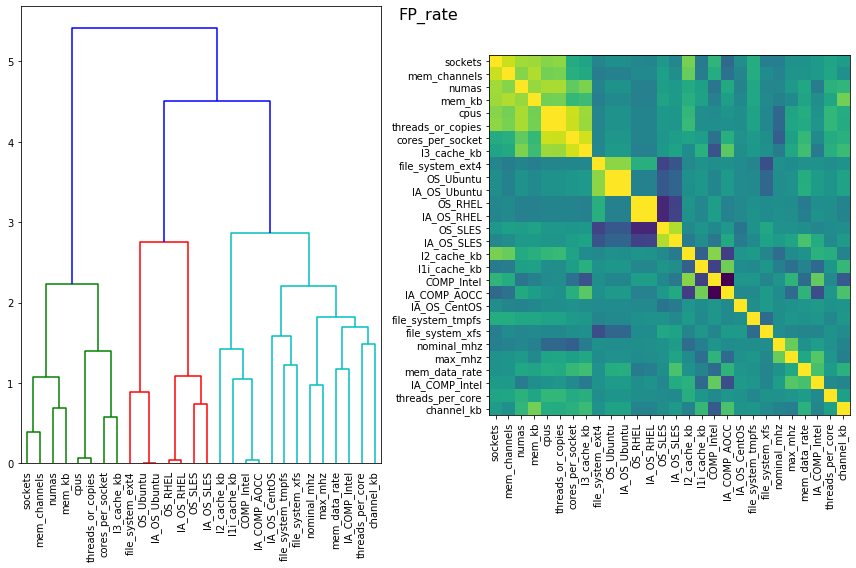

Selected features: 24
Removed features: Index(['threads_or_copies', 'IA_OS_RHEL', 'IA_OS_Ubuntu', 'IA_COMP_AOCC'], dtype='object')
Scores for transformed vectors using the RF eval:
Fitting time: 0.4278
Num of features: 24
Cross-validation MAE: 9.3648
Cross-validation R2: 0.9367
Prediction time: 0.0105
MAE on Test:: 6.7351
MAPE on Test:: 2.82%
R2 on Test: 0.99



***** FP_speed *****


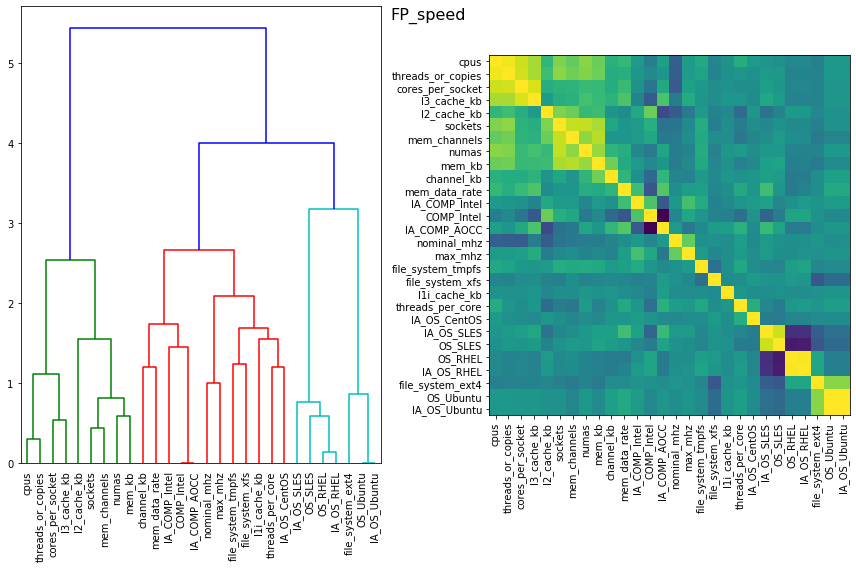

Selected features: 24
Removed features: Index(['threads_or_copies', 'IA_OS_RHEL', 'IA_OS_Ubuntu', 'IA_COMP_AOCC'], dtype='object')
Scores for transformed vectors using the RF eval:
Fitting time: 0.2778
Num of features: 24
Cross-validation MAE: 4.6524
Cross-validation R2: 0.9727
Prediction time: 0.0084
MAE on Test:: 4.5042
MAPE on Test:: 3.49%
R2 on Test: 0.98



***** Int_rate *****


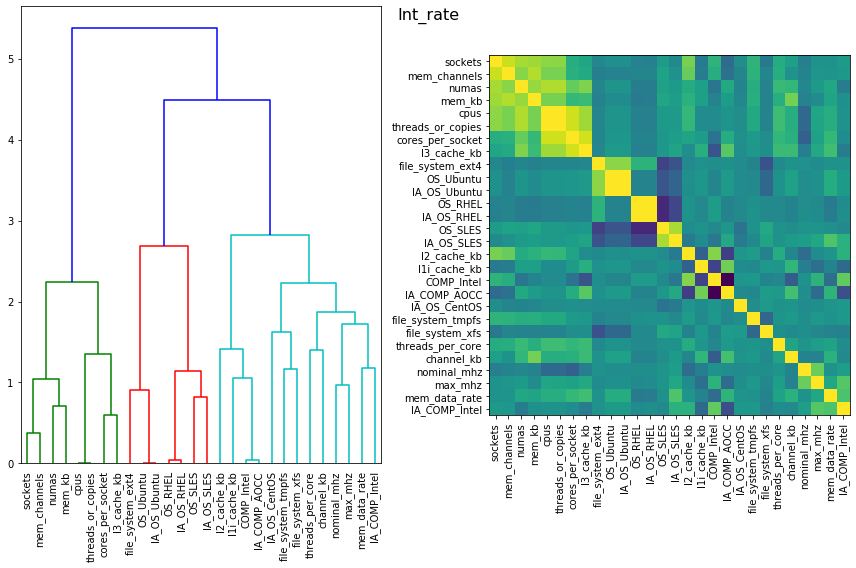

Selected features: 24
Removed features: Index(['threads_or_copies', 'IA_OS_RHEL', 'IA_OS_Ubuntu', 'IA_COMP_AOCC'], dtype='object')
Scores for transformed vectors using the RF eval:
Fitting time: 0.3528
Num of features: 24
Cross-validation MAE: 7.0469
Cross-validation R2: 0.9781
Prediction time: 0.0105
MAE on Test:: 5.5652
MAPE on Test:: 2.30%
R2 on Test: 1.00



***** Int_speed *****


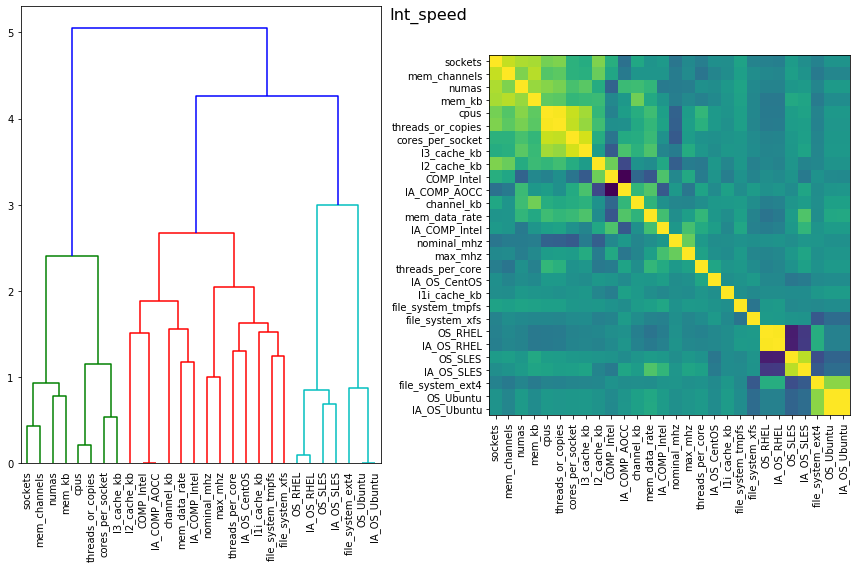

Selected features: 24
Removed features: Index(['threads_or_copies', 'IA_OS_RHEL', 'IA_OS_Ubuntu', 'IA_COMP_AOCC'], dtype='object')
Scores for transformed vectors using the RF eval:
Fitting time: 0.2939
Num of features: 24
Cross-validation MAE: 0.1497
Cross-validation R2: 0.9730
Prediction time: 0.0081
MAE on Test:: 0.1439
MAPE on Test:: 1.47%
R2 on Test: 0.97




In [5]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_02_fs_lowvar.pkl")
warnings.simplefilter(action="default")

from predict import feature_select

from predict.parameters import * # all the parameters

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))
    corr_fs = feature_select.RemoveCorrFeatures(threshold=CLUSTER_TH)
    corr_fs.dendrogram(sel_train_X_df[cat], cat)
    corr_fs.fit_transform(sel_train_X_df[cat])
    print("Selected features:", corr_fs.get_support().count(True))
    print(
        "Removed features:",
        sel_train_X_df[cat].columns[np.invert(corr_fs.get_support())]
    )
    # update `sel_` dataframes
    sel_train_X_df[cat] = sel_train_X_df[cat].iloc[:, corr_fs.get_support()]
    sel_test_X_df[cat] = sel_test_X_df[cat].iloc[:, corr_fs.get_support()]
 
    #####
    # check scores
    print(colored("Scores for transformed vectors using the RF eval:" ,"green"))
    model_regress.check_scores(
        fs_RF,
        sel_train_X_df[cat],
        train_y_df[cat],
        sel_test_X_df[cat],
        test_y_df[cat],
        k_fold,
    )

#####
# save the notebook session
dill.dump_session("pickles/regress_02_vis_fs_corr.pkl")   

## 2.2 Pipe: Remove highly correlated features

- Use the same steps as above, but do it in the Pipeline and inside the CV loop 

In [8]:
# %reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_02_fs_lowvar.pkl")
warnings.simplefilter(action="default")

from predict import feature_select

from sklearn import feature_selection
from sklearn.model_selection import cross_val_score
from predict import feature_select

pipe.steps.insert(
    -1, ("corr_fs", feature_select.RemoveCorrFeatures(threshold=CLUSTER_TH))
)

print("Pipeline Steps: " + str(pipe.named_steps.keys()))
print("Initial num features: ", len(list(train_X_df[cat])))

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    regr = model_regress.RegrModel("pipe with the RF eval", pipe)
    regr.fit(train_X_df[cat], train_y_df[cat], verbose=False)
    regr.predict(test_X_df[cat], test_y_df[cat])
    print("Print scores for the regression model:", regr)

    #####
    # check scores
    print(colored("Same results: pass the pipe with RF eval to check_scores():", "green"))
    model_regress.check_scores(
        pipe, 
        train_X_df[cat], 
        train_y_df[cat], 
        test_X_df[cat], 
        test_y_df[cat], 
        k_fold
    )

#####
# save the notebook session
dill.dump_session("pickles/regress_02_fs_corr.pkl")


Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'eval'])
Initial num features:  29

***** FP_rate *****
Print scores for the regression model: pipe with the RF eval
CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')
avg r2: 0.9863, avg mae: 6.7351, avg mape: 2.82, median mape: 2.91, train time: 0.3650, mean_pred time: 0.0097
n_features: 24
Pipeline Steps: dict_keys(['transform_X', 'reorder_X', 'debug1', 'scale', 'debug2', 'variance_fs', 'corr_fs', 'eval'])
----------

Same results: pass the pipe with RF eval to check_scores():
Fitting time: 0.3822
Num of features: 24
Cross-validation MAE: 9.4302
Cross-validation R2: 0.9349
Prediction time: 0.011
MAE on Test:: 6.7351
MAPE on Test:: 2.8

# 3. Feature Selection with feature importance and RFE

## 3.1 Visualisation with SKlearn (no cross-validation)

- Elastic Net regularisation, Tree importance, Permutation importance (RF & MLP)
- These charts are not included in the paper

**NOTE**: feature importances will change when the features get removed one by one by RFE (even the ranking might change).  


***** FP_rate *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_SLES', 'IA_OS_CentOS',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


/home/ashkan/Repos/spec17-ml/venv/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,file_system_ext4,file_system_tmpfs,file_system_xfs
3853,-0.648475,-0.804234,0.774982,0.301743,-0.243399,1.199837,1.004482,-0.194458,0.446438,-0.335396,1.433524,0.469914,-0.797054,1.522849,0.579341,-0.455515,-0.260843,0.392011,-0.126443,0.321717,0.220177,-0.387752,-0.225587,0.74601
514,-0.830286,0.158078,0.518879,0.301743,0.562531,-0.243428,-0.177229,-0.194458,0.446438,-0.056647,0.083790,0.469914,0.821125,0.706235,0.579341,-0.455515,-0.260843,0.870617,-0.126443,0.321717,0.411771,-0.387752,-0.225587,0.74601
62,-1.012097,0.158078,0.696283,0.301743,0.965495,-0.243428,-0.177229,-0.194458,0.446438,0.082727,-0.591077,0.469914,-0.797054,-0.112746,-1.726100,2.195319,-0.260843,-1.693342,-0.126443,0.321717,0.220177,-0.387752,-0.225587,0.74601
4767,-0.830286,0.158078,0.180697,0.301743,-0.041916,-0.243428,-0.177229,-0.194458,0.446438,-0.265709,0.083790,0.469914,-0.797054,0.705925,0.579341,-0.455515,-0.260843,0.392011,-0.126443,0.321717,0.220177,-0.387752,-0.225587,0.74601
3694,0.260578,0.735465,0.696283,0.301743,0.965495,-0.243428,-0.177229,-0.194458,0.446438,0.082727,0.083790,0.469914,0.821125,0.707670,-1.726100,2.195319,-0.260843,-1.693342,-0.126443,0.321717,0.406244,-0.387752,-0.225587,0.74601


[1.78251198e-02 6.38921865e-03 8.91085598e-01 4.10845911e-03
 2.86024980e-03 1.72012215e-02 7.83209544e-03 6.67009357e-05
 1.21095209e-03 3.03691275e-02 3.73430300e-03 1.51071563e-04
 4.83514514e-03 3.17897735e-03 7.07202899e-05 1.00722324e-04
 1.70251583e-04 1.70481214e-04 3.46949233e-05 0.00000000e+00
 8.24604611e-03 1.36697322e-04 7.30144767e-05 1.49131656e-04]
sum of DT importances should be 1: 1.00
Sorted DT importances Train indexes (low to high): [19 18  7 14 22 15 21 23 11 16 17  8  4 13 10  3 12  1  6 20  5  0  9  2]
Sorted DT sklearn PI Test indexes (low to high): [19 18 14 15 16 22  7 21 17 11 23  8 12  1  6  3  0 10 13  4 20  9  5  2]
[1.07925868e-02 1.69286520e-02 5.01042859e-01 3.19756479e-03
 7.53577603e-02 6.85049936e-02 7.41641306e-02 1.16124991e-03
 1.17279550e-02 1.63801101e-01 3.28588905e-02 5.50372618e-04
 4.37259467e-03 2.55116759e-02 1.30336797e-04 1.40708732e-04
 1.58384616e-04 1.53173470e-03 7.37136985e-05 9.40830749e-04
 6.54145878e-03 1.41281996e-04 9.2261750

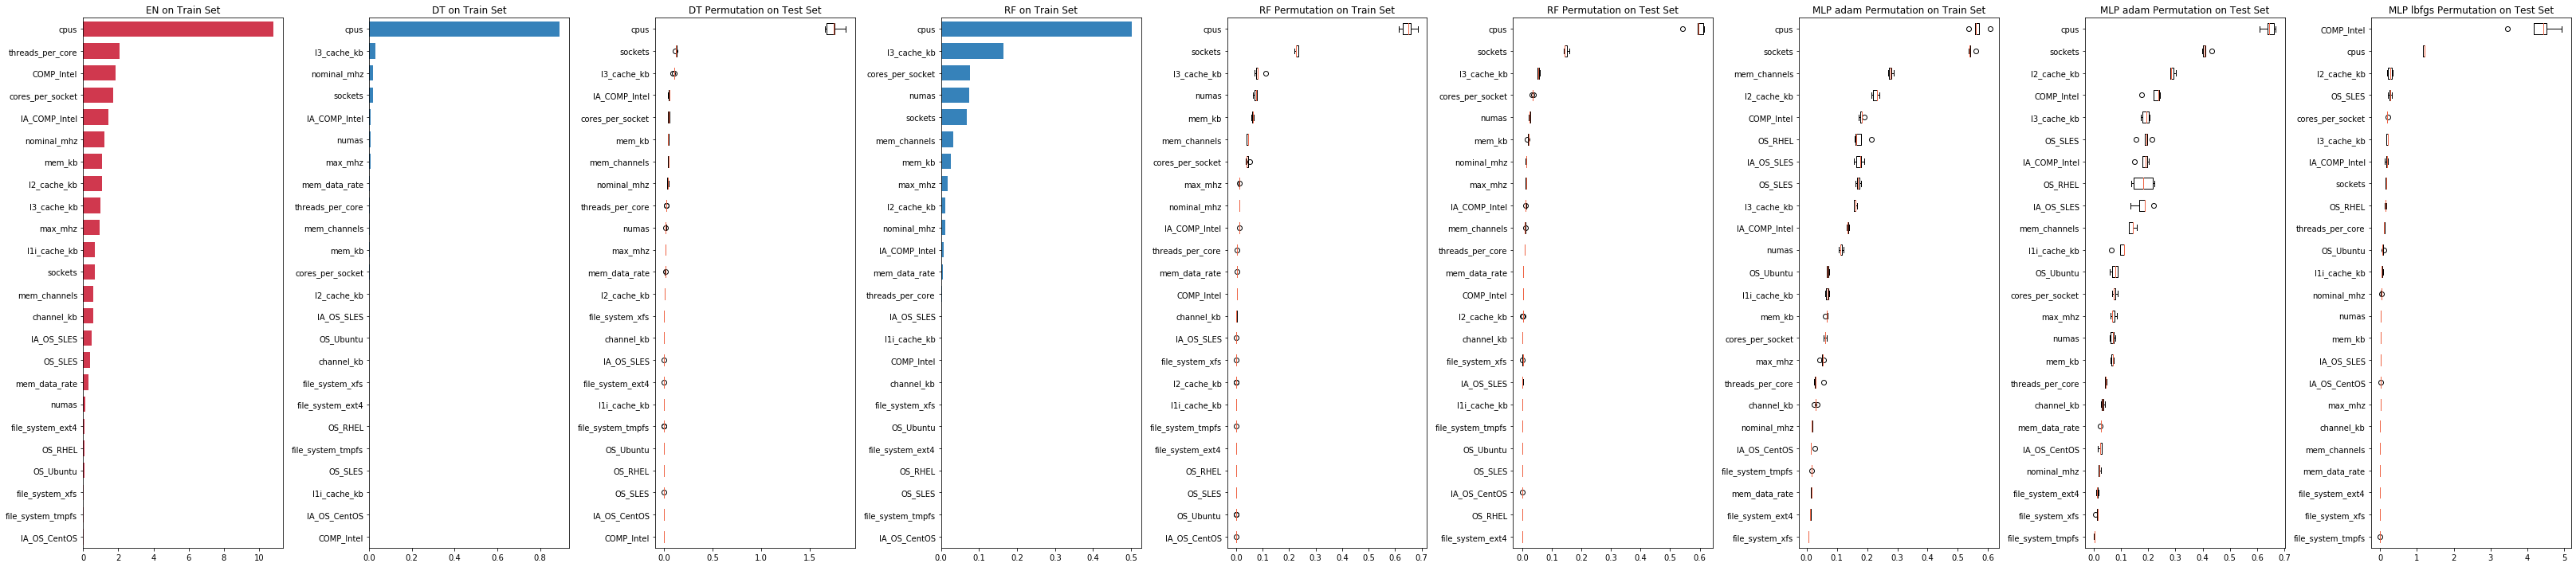


***** FP_speed *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_SLES', 'IA_OS_CentOS',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,file_system_ext4,file_system_tmpfs,file_system_xfs
2608,-0.692797,0.654101,1.224518,2.029177,0.760665,-0.245023,0.439818,-0.034125,0.422869,0.075411,-0.667653,0.731257,0.722132,-0.020558,-1.379170,1.606951,-0.224493,-1.359250,-0.13321,0.268964,0.379906,-0.342997,4.854306,-1.311765
4007,2.164273,2.021076,-1.095523,2.029177,-1.037773,-1.201472,-0.624347,-0.034125,-2.713537,-0.497761,-1.227890,-0.846405,-0.879125,-2.144318,-1.379170,1.606951,-0.224493,-1.359250,-0.13321,0.268964,0.147324,-0.342997,-0.206003,0.762332
3408,0.200037,0.654101,0.623158,-0.492811,1.160318,-0.245023,-0.269626,-0.034125,0.422869,0.141779,-0.667653,0.731257,0.722132,-0.017340,0.725074,-0.622296,-0.224493,0.965265,-0.13321,0.268964,0.360702,-0.342997,-0.206003,-1.311765
1591,-0.871364,0.068255,0.451171,-0.492811,0.760665,-0.245023,-0.269626,-0.034125,0.422869,0.075411,-0.667653,-0.846405,0.722132,-0.849255,0.725074,-0.622296,-0.224493,0.562349,-0.13321,0.268964,0.358568,-0.342997,-0.206003,-1.311765
1615,-1.049931,0.068255,0.247754,-0.492811,0.361012,-0.245023,-0.269626,-0.034125,0.422869,-0.123691,-0.667653,0.731257,-0.879125,-0.017348,0.725074,-0.622296,-0.224493,0.531356,-0.13321,0.268964,0.143056,-0.342997,-0.206003,-1.311765


[6.52924041e-03 1.27516297e-02 7.17440339e-01 5.06500194e-04
 4.39018057e-02 6.24072322e-02 1.43828710e-03 0.00000000e+00
 1.00656898e-03 4.50147878e-02 5.71991385e-02 4.02415851e-04
 1.65149686e-03 5.84672316e-03 2.97799804e-04 2.87514579e-04
 5.29698985e-05 1.62049025e-03 4.33639627e-05 0.00000000e+00
 4.02899919e-02 3.98190235e-04 3.67329102e-04 5.46184362e-04]
sum of DT importances should be 1: 1.00
Sorted DT importances Train indexes (low to high): [19  7 18 16 15 14 22 21 11  3 23  8  6 17 12 13  0  1 20  4  9 10  5  2]
Sorted DT sklearn PI Test indexes (low to high): [22 16 19  7 18 15 21 14 11  3 23  8 17  6 12  1  0 10  4  9 13 20  5  2]
[1.11147376e-02 2.52182631e-02 3.82343961e-01 2.87040078e-03
 1.11692761e-01 7.64539260e-02 2.23288628e-02 8.66429771e-06
 2.26295268e-02 1.75463211e-01 7.26968595e-02 6.81824228e-04
 6.74224211e-03 5.28703520e-02 4.42104336e-04 3.59518871e-04
 2.26817498e-04 2.11870301e-03 6.36040869e-05 6.66528187e-04
 3.13401664e-02 3.34965236e-04 7.7104655

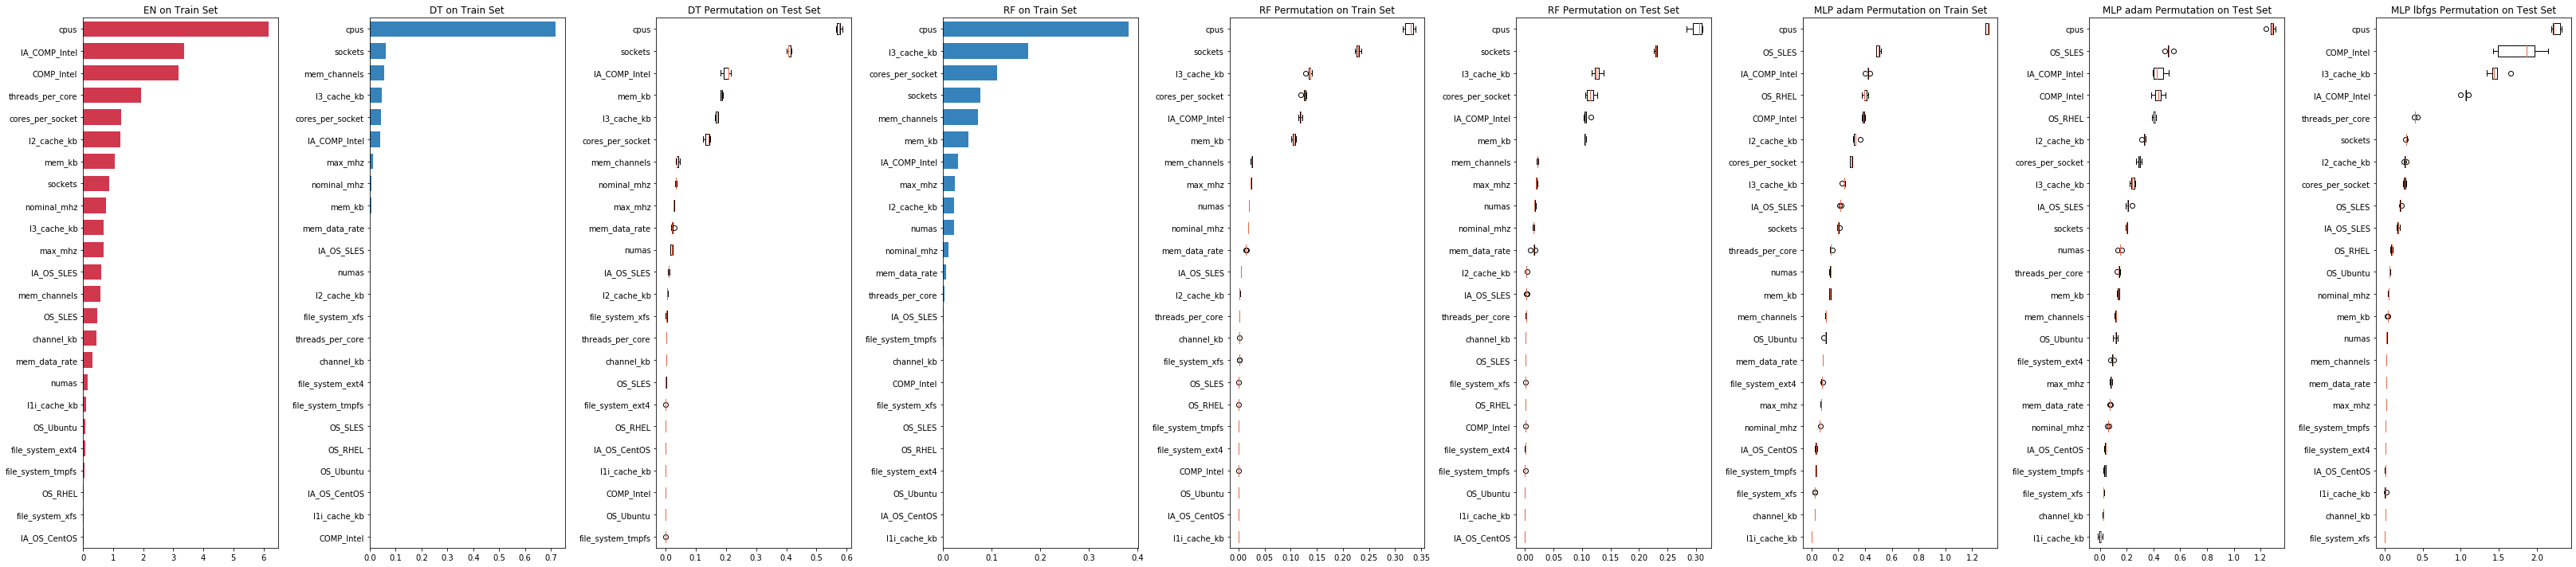


***** Int_rate *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_SLES', 'IA_OS_CentOS',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_SLES,IA_OS_CentOS,COMP_Intel,IA_COMP_Intel,file_system_ext4,file_system_tmpfs,file_system_xfs
2395,-1.374634,-0.036034,0.387645,0.24964,0.366005,-0.254459,-0.191493,-0.189093,0.442026,-0.123750,0.068586,0.487081,0.820156,0.689466,0.547107,-0.423869,-0.256205,0.844625,-0.129326,0.314970,0.404564,-0.386108,-0.264114,0.778330
2567,-0.826026,0.154654,1.222641,0.24964,0.570510,1.190466,0.983581,-0.189093,0.442026,-0.053284,1.407424,-0.854795,-0.797804,0.687783,0.547107,-0.423869,-0.256205,0.370395,-0.129326,0.314970,0.213515,-0.386108,-0.264114,0.778330
5356,-0.826026,0.726716,0.387645,0.24964,0.366005,-0.254459,-0.191493,-0.189093,0.442026,-0.123750,-0.600833,-0.854795,0.820156,-0.930138,0.547107,-0.423869,-0.256205,0.862189,-0.129326,0.314970,0.417675,-0.386108,-0.264114,0.778330
3698,-0.826026,-1.752221,0.151330,0.24964,-0.043005,-0.254459,0.983581,5.288414,-1.662226,-0.008442,-0.377694,3.170832,-0.797804,1.020827,-1.827797,-0.423869,3.903131,-1.789986,-0.129326,-3.174902,-3.161679,2.589947,-0.264114,-1.284803
833,-1.008895,-0.512752,1.619450,0.24964,4.865119,-0.254459,0.983581,-0.189093,-1.662226,5.731288,-0.377694,3.170832,2.438115,1.025617,-1.827797,-0.423869,3.903131,-1.789986,-0.129326,-3.174902,-3.161679,2.589947,-0.264114,-1.284803


[2.07407519e-02 5.15261442e-03 9.54287819e-01 7.63834546e-04
 6.87145944e-03 4.36293322e-04 3.53415377e-04 1.44634353e-05
 4.38521856e-04 3.83049448e-03 1.66301893e-04 6.48776873e-05
 1.31878899e-03 8.41895523e-04 4.29462935e-05 3.80164277e-05
 4.43359463e-05 1.70239398e-04 7.18807299e-05 3.91833558e-04
 3.81924329e-03 3.35544908e-05 2.06208590e-05 8.57968945e-05]
sum of DT importances should be 1: 1.00
Sorted DT importances Train indexes (low to high): [ 7 22 21 15 14 16 11 18 23 10 17  6 19  5  8  3 13 12 20  9  1  4  0  2]
Sorted DT sklearn PI Test indexes (low to high): [15  7 16 14 21 11 23 18 22 10  3 17  8  6 19 12  4  5 13  1  9 20  0  2]
[1.16001375e-02 1.20797434e-02 5.56097258e-01 1.35426131e-03
 1.65221874e-01 3.21103960e-02 6.10740760e-02 1.09206495e-03
 9.38681873e-04 1.05006553e-01 2.54215509e-02 2.17661033e-04
 4.08508872e-03 1.75879851e-02 6.18330361e-05 5.17533193e-05
 4.95518459e-05 1.00678457e-03 6.93955864e-05 4.32192192e-04
 4.18317136e-03 7.13135571e-05 3.8734396

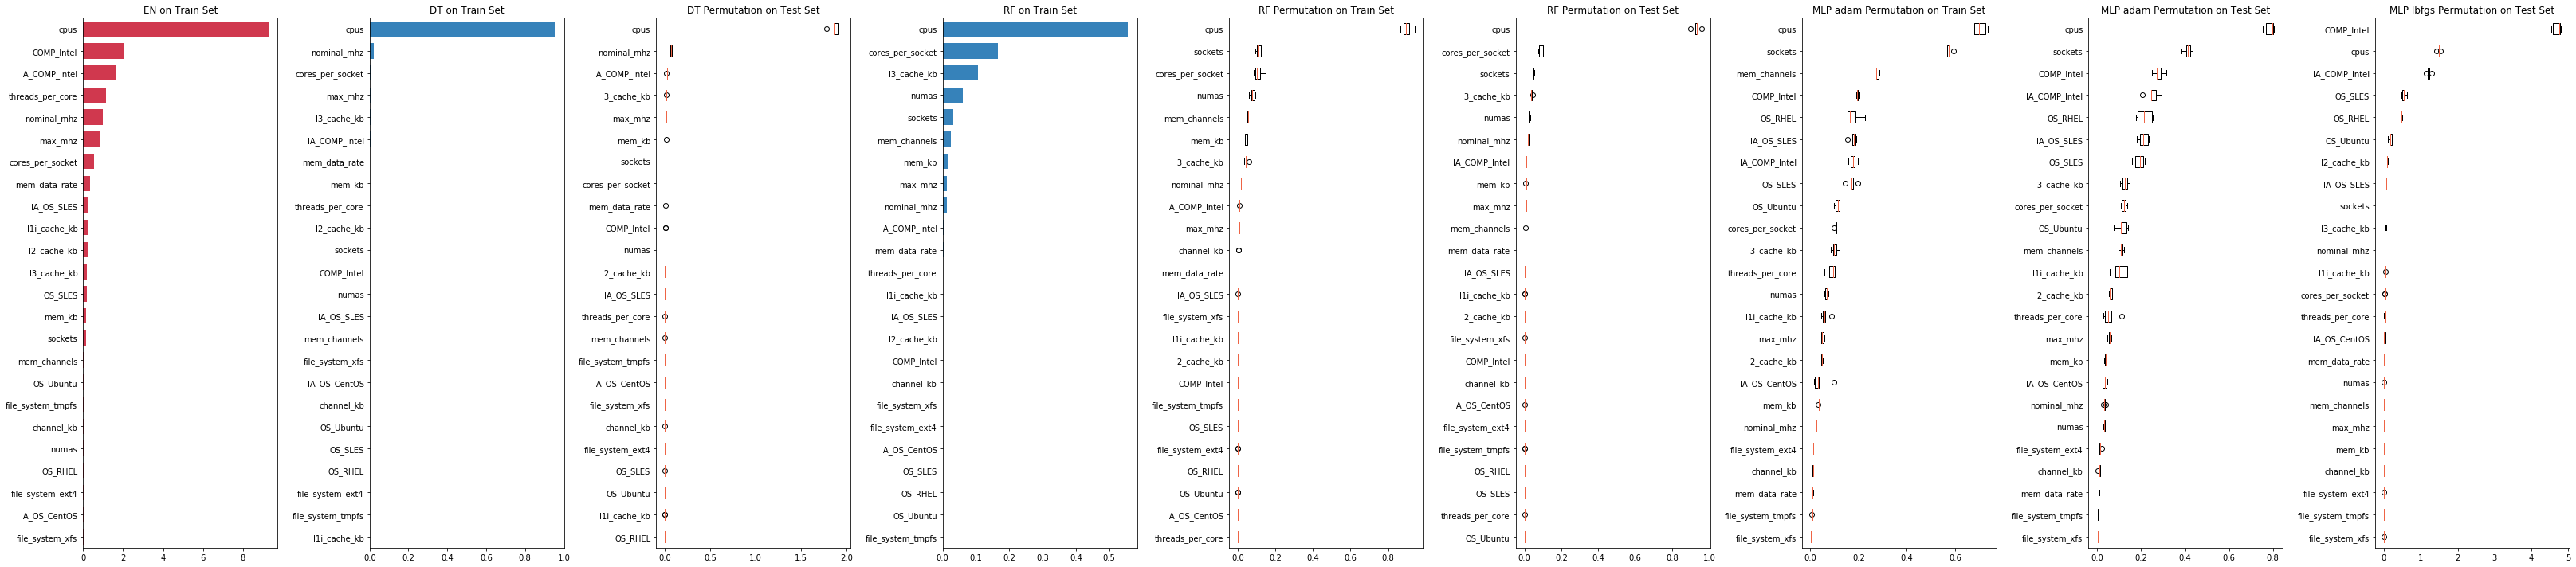


***** Int_speed *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_CentOS', 'IA_OS_SLES',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


,nominal_mhz,max_mhz,cpus,threads_per_core,cores_per_socket,sockets,numas,l1i_cache_kb,l2_cache_kb,l3_cache_kb,mem_channels,channel_kb,mem_data_rate,mem_kb,OS_SLES,OS_RHEL,OS_Ubuntu,IA_OS_CentOS,IA_OS_SLES,COMP_Intel,IA_COMP_Intel,file_system_ext4,file_system_tmpfs,file_system_xfs
1304,-1.044861,-1.278215,-0.831188,-0.644170,-0.831097,-0.238385,-0.283441,-0.03813,0.41654,-0.519577,-0.660086,0.717521,-0.871014,-0.018417,0.627509,-0.527633,-0.224322,-0.130794,0.432798,0.264381,0.137642,-0.340068,-0.175582,-1.288998
1125,0.194079,0.642035,1.243860,1.552386,1.001099,-0.238385,-0.283441,-0.03813,0.41654,0.089434,0.173376,-0.850463,0.739953,-0.018462,0.627509,-0.527633,-0.224322,-0.130794,0.465571,0.264381,0.356400,-0.340068,-0.175582,-1.288998
1323,0.194079,0.065960,1.155126,-0.644170,0.797522,1.686579,0.440185,-0.03813,0.41654,0.021766,1.840300,0.717521,-0.871014,1.624731,-1.593602,1.895257,-0.224322,-0.130794,-1.566301,0.264381,0.137642,-0.340068,-0.175582,0.775797
3902,0.017088,0.450010,0.836207,1.552386,0.186790,-0.238385,-0.283441,-0.03813,0.41654,-0.181237,-0.660086,-0.850463,0.739953,-0.841545,0.627509,-0.527633,-0.224322,-0.130794,0.465571,0.264381,0.362898,-0.340068,-0.175582,-1.288998
1934,0.194079,0.642035,0.475449,-0.644170,1.001099,-0.238385,-0.283441,-0.03813,0.41654,0.089434,0.173376,-0.850463,0.739953,-0.022790,0.627509,-0.527633,-0.224322,-0.130794,0.465571,0.264381,0.356400,-0.340068,-0.175582,0.775797


[1.06962140e-02 6.51422568e-01 4.75954544e-02 4.93082473e-03
 2.38871273e-02 1.02633575e-03 2.33166874e-03 1.76594207e-04
 9.80913039e-04 3.32207886e-02 1.20216174e-01 1.51780303e-03
 1.52097165e-02 6.11075920e-03 8.73432797e-04 4.23730060e-04
 4.84641376e-04 4.52674120e-04 6.14298128e-03 2.83951664e-02
 4.23889498e-02 9.62533729e-04 3.02540149e-05 5.22694341e-04]
sum of DT importances should be 1: 1.00
Sorted DT importances Train indexes (low to high): [22  7 15 17 16 23 14 21  8  5 11  6  3 13 18  0 12  4 19  9 20  2 10  1]
Sorted DT sklearn PI Test indexes (low to high): [ 7 17 22 15 16 23  5  8 14 21  6 11 13  3  0 18  2  4 12 19  9 10 20  1]
[1.07861325e-01 4.41050597e-01 5.67899949e-02 3.87429281e-03
 3.84567233e-02 4.11993808e-03 1.02044771e-02 3.06917755e-04
 1.86383147e-02 1.39433573e-01 3.01342632e-02 1.50329723e-03
 1.43400692e-02 3.47218041e-02 1.18748388e-03 6.04125553e-04
 8.33585233e-04 1.67914556e-04 9.45802441e-03 1.01389042e-02
 7.38902246e-02 1.21658350e-03 1.9942091

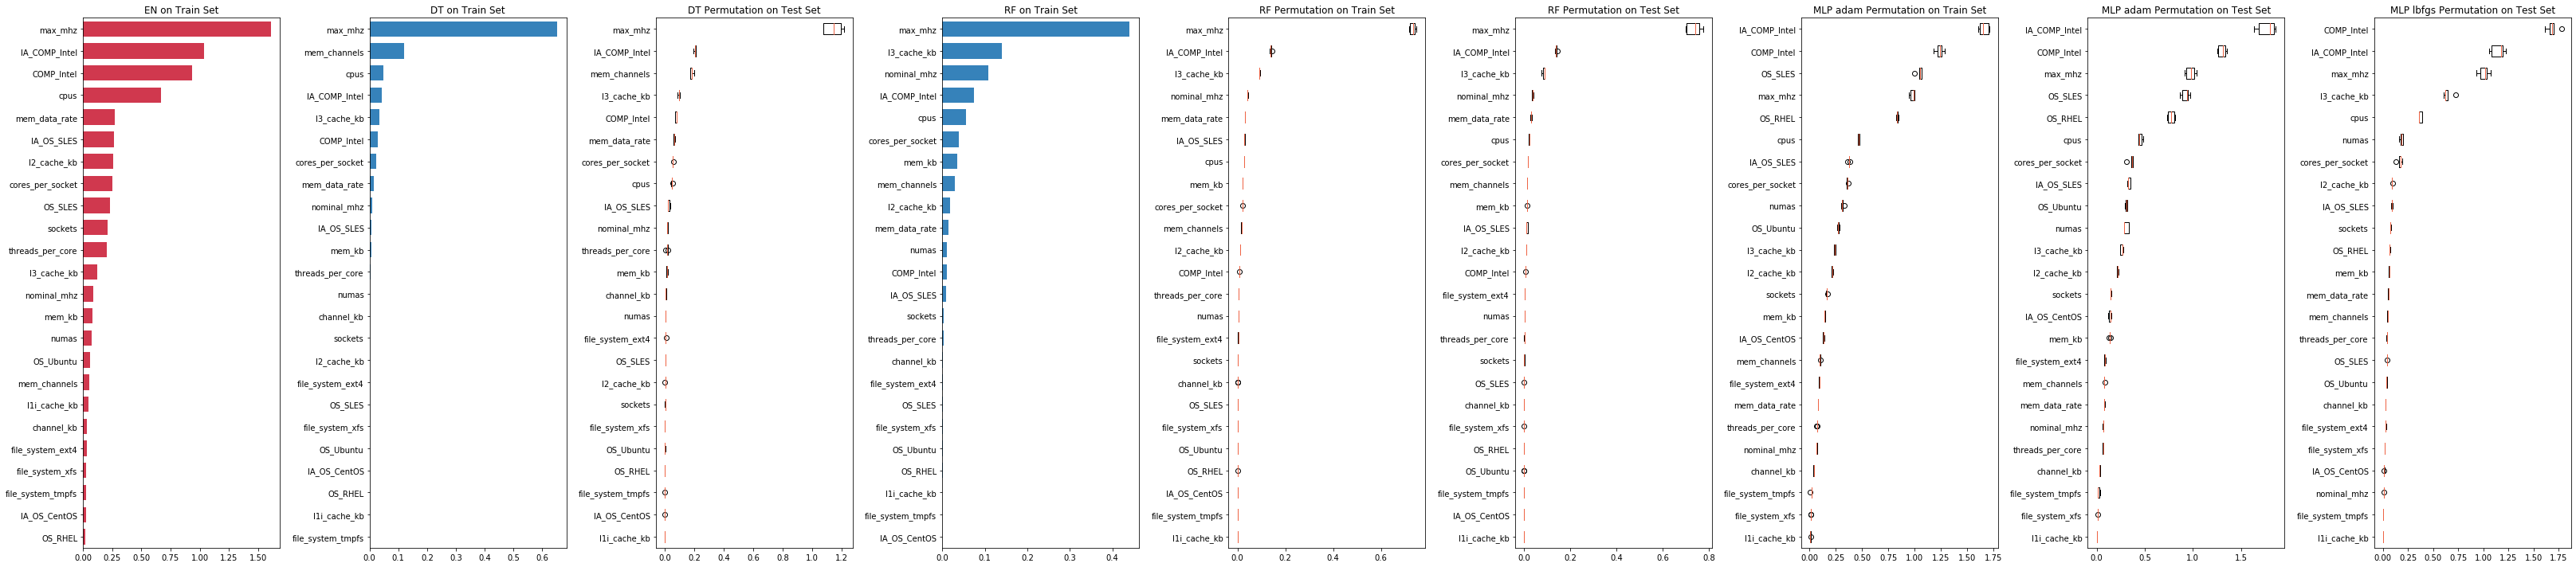

In [9]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_02_vis_fs_corr.pkl")
warnings.simplefilter(action="default")

from sklearn.inspection import permutation_importance
import seaborn as sns
import matplotlib.pyplot as plt

# seed for manual permutations
np.random.seed(RS)

sns.set_palette("Spectral", 10, color_codes=True)
red = sns.color_palette()[0]
blue = sns.color_palette()[9]

fs_EN_fit, fs_DT_fit, fs_RF_fit, fs_MLP_adam_fit, fs_MLP_lbfgs_fit = {}, {}, {}, {}, {}

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))
    sel_feature_names = sel_train_X_df[cat].columns
    print('Number of sel_ dfs features:', len(sel_feature_names))
    if VERBOSE:
        print('sel_ dfs features:', sel_feature_names)
        display(sel_train_X_df[cat].head())

    ##########
    # fs: Elastic Net
    # fit
    fs_EN_fit[cat] = fs_EN.fit(sel_train_X_df[cat], train_y_df[cat])
    # coefs, got the norm formula it from:
    # https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/feature_selection/_from_model.py#L83
    coef_lianlg = np.linalg.norm(fs_EN_fit[cat].coef_, axis=0, ord=1)
    coef_df = pd.DataFrame({'EN_coef_lianlg': coef_lianlg, 'feature': sel_feature_names})
    coef_df.sort_values(by=['EN_coef_lianlg'], inplace=True, ascending=True)
    
    ##########
    # fs: Decsion Tree
    # fit
    fs_DT_fit[cat] = fs_DT.fit(sel_train_X_df[cat], train_y_df[cat])
    print(fs_DT_fit[cat].feature_importances_)
    dt_importance_sorted_idx = np.argsort(fs_DT_fit[cat].feature_importances_)
    print("sum of DT importances should be 1: {:.2f}".format(sum(fs_DT.feature_importances_)))
    if VERBOSE:
        print("Sorted DT importances Train indexes (low to high):", dt_importance_sorted_idx) 

    #####
    # DT PI on test
    dt_pi_result_test = permutation_importance(
        fs_DT_fit[cat], sel_test_X_df[cat], test_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    dt_pi_test_sorted_idx = np.argsort(dt_pi_result_test.importances_mean)
    if VERBOSE:
        print("Sorted DT sklearn PI Test indexes (low to high):", dt_pi_test_sorted_idx) 

    ##########
    # fs: Random Forest
    # fit
    fs_RF_fit[cat] = fs_RF.fit(sel_train_X_df[cat], train_y_df[cat])
    print(fs_RF_fit[cat].feature_importances_)
    rf_importance_sorted_idx = np.argsort(fs_RF_fit[cat].feature_importances_)
    print("sum of RF importances should be 1: {:.2f}".format(sum(fs_RF.feature_importances_)))
    if VERBOSE:
        print("Sorted RF importances Train indexes (low to high):", rf_importance_sorted_idx) 

    #####
    # fs: RF Permutation Importance
    # fitted above, no need to fit again
    # RF PI on train  
    rf_pi_result_train = permutation_importance(
        fs_RF_fit[cat], sel_train_X_df[cat], train_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    rf_pi_train_sorted_idx = np.argsort(rf_pi_result_train.importances_mean)
    if VERBOSE:
        print("Sorted RF sklearn PI Train indexes (low to high):", rf_pi_train_sorted_idx)
    
    # RF PI on test
    rf_pi_result_test = permutation_importance(
        fs_RF_fit[cat], sel_test_X_df[cat], test_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    rf_pi_test_sorted_idx = np.argsort(rf_pi_result_test.importances_mean)
    if VERBOSE:
        print("Sorted RF sklearn PI Test indexes (low to high):", rf_pi_test_sorted_idx) 

    #####
    # double check feature importance on a single feature
    if VERBOSE:   
        copy_X_train_sel = sel_train_X_df[cat].copy()
        #######
        # manually permutate and see the differences in score
        # no need to refit, as it's been fitted on the identetical copy
        # fs_RF.fit(copy_X_train_sel, train_y_df[cat])
        copy_X_train_sel['cpus'] = np.random.permutation(sel_train_X_df[cat]['cpus'])
        print("RF score on copy_X_train_sel with `cpus` permutated: {:.4f}".format(
            fs_RF.score(copy_X_train_sel, train_y_df[cat])))
    #####

    ##########
    # fs: MLP adam Permutation Importance
    # fit
    fs_MLP_adam_fit[cat] = fs_MLP_adam.fit(sel_train_X_df[cat], train_y_df[cat]) 
    # MLP adam PI on train  
    mlp_adam_pi_result_train = permutation_importance(
        fs_MLP_adam_fit[cat], sel_train_X_df[cat], train_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    mlp_adam_pi_train_sorted_idx = np.argsort(mlp_adam_pi_result_train.importances_mean)
    if VERBOSE:
        print("Sorted mlp adam sklearn PI Train indexes (low to high):", mlp_adam_pi_train_sorted_idx)
    
    # MLP adam PI on test
    mlp_adam_pi_result_test = permutation_importance(
        fs_MLP_adam_fit[cat], sel_test_X_df[cat], test_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    mlp_adam_pi_test_sorted_idx = np.argsort(mlp_adam_pi_result_test.importances_mean)
    if VERBOSE:
        print("Sorted mlp adam sklearn PI Test indexes (low to high):", mlp_adam_pi_test_sorted_idx) 
    
    #####
    # double check feature importance on a single feature
    if VERBOSE:   
        copy_X_train_sel = sel_train_X_df[cat].copy()
        # no need to refit
        # fs_MLP.fit(copy_X_train_sel, train_y_df[cat])
        copy_X_train_sel['COMP_Intel'] = np.random.permutation(sel_train_X_df[cat]['COMP_Intel'])
        print("MLP adam Score on copy_X_train_sel with `COMP_Intel` permutated: {:.4f}".format(
            fs_MLP_adam.score(copy_X_train_sel, train_y_df[cat])))
    #####

    ##########
    # fs: MLP lbfgs Permutation Importance
    # fit
    fs_MLP_lbfgs_fit[cat] = fs_MLP_lbfgs.fit(sel_train_X_df[cat], train_y_df[cat]) 
    # MLP lbfgs PI on train  
    mlp_lbfgs_pi_result_train = permutation_importance(
        fs_MLP_lbfgs_fit[cat], sel_train_X_df[cat], train_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    mlp_lbfgs_pi_train_sorted_idx = np.argsort(mlp_lbfgs_pi_result_train.importances_mean)
    if VERBOSE:
        print("Sorted mlp lbfgs sklearn PI Train indexes (low to high):", mlp_lbfgs_pi_train_sorted_idx)
    
    # MLP adam PI on test
    mlp_lbfgs_pi_result_test = permutation_importance(
        fs_MLP_lbfgs_fit[cat], sel_test_X_df[cat], test_y_df[cat], 
        n_repeats=PI_N_REPS, n_jobs=PI_N_JOBS, random_state=RS
    )
    mlp_lbfgs_pi_test_sorted_idx = np.argsort(mlp_lbfgs_pi_result_test.importances_mean)
    if VERBOSE:
        print("Sorted mlp lbfgs sklearn PI Test indexes (low to high):", mlp_lbfgs_pi_test_sorted_idx) 
    
    ##########
    # plot
    fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9, figsize=(45, 10))
    plot_indices = np.arange(0, len(coef_df)) + 0.5  
    
    ax1.barh(
        plot_indices,
        coef_df['EN_coef_lianlg'], 
        height=0.7,
        color=red
    )
    ax1.set_yticklabels(coef_df['feature'])
    ax1.set_yticks(plot_indices)
    ax1.set_ylim((0, len(coef_df)))
    ax1.title.set_text("EN on Train Set" )

    ax2.barh(
        plot_indices,
        fs_DT.feature_importances_[dt_importance_sorted_idx], 
        height=0.7, 
        color=blue
    )
    ax2.set_yticklabels(sel_feature_names[dt_importance_sorted_idx])
    ax2.set_yticks(plot_indices)
    ax2.set_ylim((0, len(fs_DT.feature_importances_)))
    ax2.title.set_text("DT on Train Set")

    ax3.boxplot(
        dt_pi_result_test.importances[dt_pi_test_sorted_idx].T, 
        vert=False,
        labels=sel_feature_names[dt_pi_test_sorted_idx]
    )
    ax3.title.set_text("DT Permutation on Test Set")

    ax4.barh(
        plot_indices,
        fs_RF.feature_importances_[rf_importance_sorted_idx], 
        height=0.7, 
        color=blue
    )
    ax4.set_yticklabels(sel_feature_names[rf_importance_sorted_idx])
    ax4.set_yticks(plot_indices)
    ax4.set_ylim((0, len(fs_RF.feature_importances_)))
    ax4.title.set_text("RF on Train Set")

    ax5.boxplot(
        rf_pi_result_train.importances[rf_pi_train_sorted_idx].T, 
        vert=False,
        labels=sel_feature_names[rf_pi_train_sorted_idx]
    )
    ax5.title.set_text("RF Permutation on Train Set")

    ax6.boxplot(
        rf_pi_result_test.importances[rf_pi_test_sorted_idx].T, 
        vert=False,
        labels=sel_feature_names[rf_pi_test_sorted_idx]
    )
    ax6.title.set_text("RF Permutation on Test Set")

    ax7.boxplot(
        mlp_adam_pi_result_train.importances[mlp_adam_pi_train_sorted_idx].T, 
        vert=False,
        labels=sel_feature_names[mlp_adam_pi_train_sorted_idx]
    )
    ax7.title.set_text("MLP adam Permutation on Train Set")

    ax8.boxplot(
        mlp_adam_pi_result_test.importances[mlp_adam_pi_test_sorted_idx].T, 
        vert=False,
        labels=sel_feature_names[mlp_adam_pi_test_sorted_idx]
    )
    ax8.title.set_text("MLP adam Permutation on Test Set")

    # lbfgs
    ax9.boxplot(
        mlp_lbfgs_pi_result_test.importances[mlp_lbfgs_pi_test_sorted_idx].T, 
        vert=False,
        labels=sel_feature_names[mlp_lbfgs_pi_test_sorted_idx]
    )
    ax9.title.set_text("MLP lbfgs Permutation on Test Set")

    fig.tight_layout()
    plt.show()    

    # # check scores
    # print(
    #     colored(
    #         "Scores for transformed vectors using RF eval (similar to 2.2 since nothing has changed):", 
    #         "green",
    #     )
    # )
    # model_regress.check_scores(
    #     baseline_eval,
    #     sel_train_X_df[cat],
    #     train_y_df[cat],
    #     sel_test_X_df[cat],
    #     test_y_df[cat],
    #     k_fold,
    # )

#####
# save the notebook session
dill.dump_session("pickles/regress_02_vis_fs_importance.pkl")  


## 3.2 Visualisation with ELI5 (cross-validation): RFECV: EN, RF, RF_PI, MLP_PI

1. `RFECV`: get CV scores for 1 to max number of features and then choose `k` as the optimal number of features that provides the best score. `ranking_` will be provided for the whole training set

2. `RFE`: choose the `k` provided by `RFECV` or choose an appropriate `k` based on the chart, here we use `k=10` based on the charts
  - **train-test score**: `support_` and `ranking_` of `RFE` can be obtained on the whole training set, so the scores will be the same as if you fit the result of the `RFECV`
  - **cross-validation score**: `cross_val_score` of a `Pipeline` containing `RFE` with `n_features_to_select=k` followed by the estimator of the RFE as the next step will be the same as the `grid_scores_` of the `RFECV` for `k` features

**NOTE**: when using `RFECV` with `PermutationImportance`, we need to pass a `Pipeline` to the `check_scores()` function, because `PermutationImportance` doesn't provide an `estimator_`


***** FP_rate *****
Number of features in transformed dfs: 24
Regressor: MultiTaskElasticNet
Sel_RFECV Scores for transformed vectors:
Fitting time: 33.8387
Num of features: 21
Prediction time: 0.0362
MAE on Test:: 14.0120
MAPE on Test:: 6.77%
R2 on Test: 0.98


Sel_RFECV Attributes:
RFECV selected features with CV: 21
ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 3 2]
support: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True False False]
grid_scores: [-43.18105757 -42.5265457  -39.19033123 -34.85052719 -29.19992658
 -21.56010014 -20.45282481 -19.34050663 -23.26035741 -22.07464348
 -20.50261178 -20.16662128 -20.16772665 -18.41188308 -17.56621545
 -16.36687933 -16.14643176 -16.01543802 -16.03772144 -16.03312492
 -15.99897355 -16.04522989 -16.05127938 -16.05096682]
Manual selection, Sel_RFE Scores for transformed vectors:
Fitting time: 29.4858
Num of features: 10
Cross-validation MAE: 22.0746
Cr

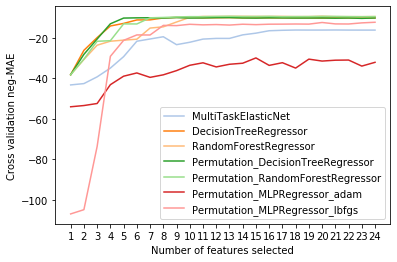


***** FP_speed *****
Number of features in transformed dfs: 24
Regressor: MultiTaskElasticNet
Sel_RFECV Scores for transformed vectors:
Fitting time: 28.2236
Num of features: 22
Prediction time: 0.0057
MAE on Test:: 10.7308
MAPE on Test:: 8.39%
R2 on Test: 0.91


Sel_RFECV Attributes:
RFECV selected features with CV: 22
ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 2]
support: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True False]
grid_scores: [-55.70665936 -53.8514396  -28.79975012 -24.55825707 -18.37932497
 -15.95839024 -13.51518636 -12.2587239  -11.72030553 -11.26509302
 -11.17553569 -11.16242371 -11.018498   -10.99328476 -10.86640513
 -10.83974497 -10.77591605 -10.75923602 -10.73537146 -10.71361932
 -10.71098746 -10.71042616 -10.71308214 -10.71488584]
Manual selection, Sel_RFE Scores for transformed vectors:
Fitting time: 20.1256
Num of features: 10
Cross-validation MAE: 11.2651
C

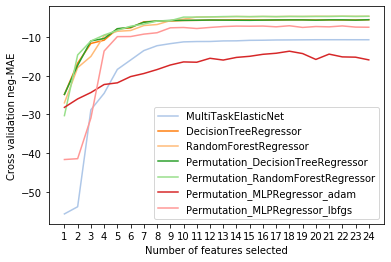


***** Int_rate *****
Number of features in transformed dfs: 24
Regressor: MultiTaskElasticNet
Sel_RFECV Scores for transformed vectors:
Fitting time: 20.5198
Num of features: 23
Prediction time: 0.006
MAE on Test:: 10.2473
MAPE on Test:: 4.61%
R2 on Test: 0.99


Sel_RFECV Attributes:
RFECV selected features with CV: 23
ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2]
support: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False]
grid_scores: [-32.54838918 -31.9051578  -28.49855553 -16.19634779 -14.84329037
 -13.74787848 -12.89003199 -11.31566729 -11.07051824 -10.96827394
 -10.75909078 -10.70049215 -10.56093091 -10.55187356 -10.61190641
 -10.61290125 -10.5014144  -10.4833774  -10.47549603 -10.4908613
 -10.44943047 -10.44590594 -10.44568191 -10.4484066 ]
Manual selection, Sel_RFE Scores for transformed vectors:
Fitting time: 16.4718
Num of features: 10
Cross-validation MAE: 10.9683
Cro

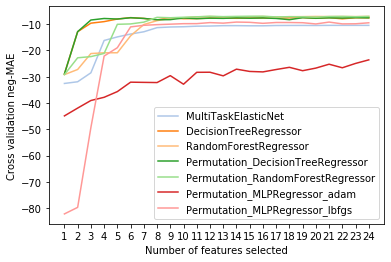


***** Int_speed *****
Number of features in transformed dfs: 24
Regressor: MultiTaskElasticNet
Sel_RFECV Scores for transformed vectors:
Fitting time: 20.155
Num of features: 24
Prediction time: 0.0057
MAE on Test:: 0.4074
MAPE on Test:: 3.93%
R2 on Test: 0.89


Sel_RFECV Attributes:
RFECV selected features with CV: 24
ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
support: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
grid_scores: [-1.40273352 -1.26121285 -0.73814627 -0.52518133 -0.45969581 -0.45199463
 -0.44435709 -0.43819528 -0.4183214  -0.41713908 -0.41618509 -0.41370845
 -0.41209806 -0.40985388 -0.40779871 -0.4050141  -0.40388573 -0.40273318
 -0.40267875 -0.40261372 -0.40265451 -0.40252201 -0.40230872 -0.40225555]
Manual selection, Sel_RFE Scores for transformed vectors:
Fitting time: 18.9297
Num of features: 10
Cross-validation MAE: 0.4171
Cross-validation R2: 0.8847


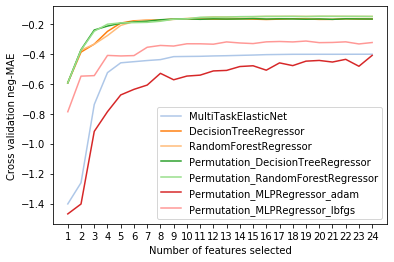

In [10]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_02_vis_fs_importance.pkl")

warnings.simplefilter(action="default")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
import matplotlib.pyplot as plt

cm = plt.get_cmap("tab20")
colors = [cm((i + 1) / len(cm.colors)) for i in range(len(cm.colors))]

sel_rfecv_pipe, sel_rfe_pipe, sel_rfe_manual_pipe = {}, {}, {}

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    sel_rfecv_pipe[cat], sel_rfe_pipe[cat], sel_rfe_manual_pipe[cat] = {}, {}, {}

    print("Number of features in transformed dfs:", len(sel_feature_names))

    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation neg-MAE")

    for e_ind, est in enumerate(RFECV_ESTS):
        sel_rfecv = RFECV(
            estimator=est,
            step=1,
            cv=k_fold,
            scoring=RFECV_SCORING,
            n_jobs=RFECV_N_JOBS,
        )
        # we need to get `evaluate` like this, because of PI and only eli5 supports it 
        # otherwise RFECV and RFE can predict using their estimators
        evaluate = (
            est
            if not isinstance(est, eli5.sklearn.PermutationImportance)
            else est.estimator
        )
        label = (
            "Permutation_" + est.estimator.regressor.__class__.__name__
            if hasattr(est, "estimator")
            else est.regressor.__class__.__name__ 
        )
        if "MLPRegressor" in label:
            label += (
                "_lbfgs"
                if "lbfgs" in str(est)
                else "_adam"
            )
        print("Regressor:", colored(label, "green"))
        # RFECV pipe
        sel_rfecv_pipe[cat][e_ind] = Pipeline([
            ("rfecv", sel_rfecv), 
            ("eval", evaluate)
        ])

        # RFECV check scores
        print(colored("Sel_RFECV Scores for transformed vectors:", "green"))
        model_regress.check_scores(
            sel_rfecv_pipe[cat][e_ind],
            sel_train_X_df[cat],
            train_y_df[cat],
            sel_test_X_df[cat],
            test_y_df[cat],
            None,  
        )

        # no need to refit after check_scores()
        print(colored("Sel_RFECV Attributes:", "green"))
        print("RFECV selected features with CV:", sel_rfecv_pipe[cat][e_ind]["rfecv"].n_features_)
        print("ranking:", sel_rfecv_pipe[cat][e_ind]["rfecv"].ranking_)
        print("support:", sel_rfecv_pipe[cat][e_ind]["rfecv"].support_)
        print("grid_scores:", sel_rfecv_pipe[cat][e_ind]["rfecv"].grid_scores_)

        # plot number of features vs. cross-validation scores using RFECV
        num_feats = range(1, len(sel_rfecv_pipe[cat][e_ind]["rfecv"].grid_scores_) + 1)
        plt.plot(
            num_feats,
            sel_rfecv_pipe[cat][e_ind]["rfecv"].grid_scores_,
            label=label,
            color=colors[e_ind],
        )
        
        #####
        # RFE using an elbow-like method for `n_features_to_select` using RFECV plot
        sel_rfe_manual = RFE(estimator=est, n_features_to_select=10, step=1)  # use the RFECV plot
        sel_rfe_manual_pipe[cat][e_ind] = Pipeline([("rfe", sel_rfe_manual), ("eval", evaluate)])

        # RFE manual check scores
        print(colored("Manual selection, Sel_RFE Scores for transformed vectors:", "green"))
        # save the fitted rfe_manual_pipe
        sel_rfe_manual_pipe[cat][e_ind] = model_regress.check_scores(
            sel_rfe_manual_pipe[cat][e_ind],
            sel_train_X_df[cat],
            train_y_df[cat],
            sel_test_X_df[cat],
            test_y_df[cat],
            k_fold,
        )
        # no need to refit, it is fitted in check_scores()
        print(
            "Manual Selected features by",
            label + ":\n",
            sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_].tolist(),
            "\n====================\n"
        )
        

    # show plot after looping over estimators
    plt.xticks(num_feats)
    plt.legend()
    plt.show()

#####
# save the notebook session
dill.dump_session("pickles/regress_02_vis_fs_rfe.pkl")


## 3.3 Save RFECV Plots

- Average cross-validation scores for varying number of features selected by RFECV. We have chosen `k=10` based on these charts.


***** FP_rate *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_SLES', 'IA_OS_CentOS',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


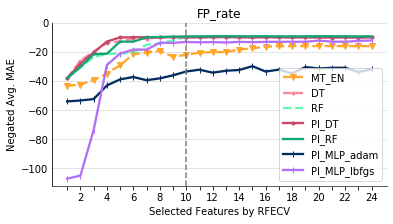


***** FP_speed *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_SLES', 'IA_OS_CentOS',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


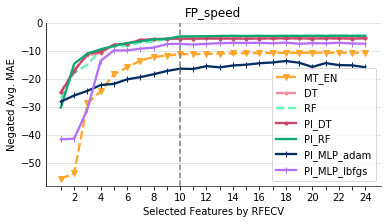


***** Int_rate *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_SLES', 'IA_OS_CentOS',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


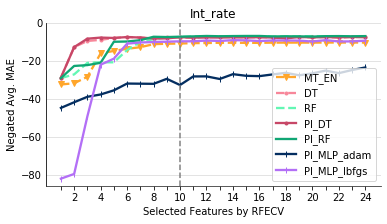


***** Int_speed *****
Number of sel_ dfs features: 24
sel_ dfs features: Index(['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core',
       'cores_per_socket', 'sockets', 'numas', 'l1i_cache_kb', 'l2_cache_kb',
       'l3_cache_kb', 'mem_channels', 'channel_kb', 'mem_data_rate', 'mem_kb',
       'OS_SLES', 'OS_RHEL', 'OS_Ubuntu', 'IA_OS_CentOS', 'IA_OS_SLES',
       'COMP_Intel', 'IA_COMP_Intel', 'file_system_ext4', 'file_system_tmpfs',
       'file_system_xfs'],
      dtype='object')


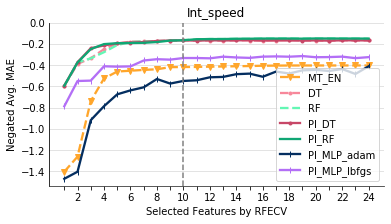

In [11]:
%reset -f

#####
# restore the notebook session
import dill
dill.load_session("pickles/regress_02_vis_fs_rfe.pkl")

from predict import visualise
sns.reset_orig()

for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))
    sel_feature_names = sel_train_X_df[cat].columns
    print('Number of sel_ dfs features:', len(sel_feature_names))
    print('sel_ dfs features:', sel_feature_names)

    visualise.plot_line_rfecv(
        rfecv_ests=RFECV_ESTS,
        rfecv_pipe=sel_rfecv_pipe,
        cat=cat,
        linewidth=2.3,
        vert_line=10,
        size=(6,3)
    )

# 4 Feature Importance for the Top-10 features

Feature importance values of the top-10 features using RFE are calculated using: coefficients for `MT_EN`, and permutation importance for `DT`, `RF`,
`MLP_adam`, and `MLP_lbfgs`.

**NOTE**: In SKlearn, we cannot pass a pipeline to `RFECV` because it changes dataframes to ndarrays in the beginning, which then results in an error when applying the `ColumnTransformer` that looks for columns. A custom `Pipeline` that exposes `coef_` and `feature_importances_` is needed. Instead, we choose `n_features_to_select` using the visualisation step above. We then get the feature importances `RFE.estimator.feature_importances_` \ `coef_` from the saved meta-estimators in 3.2. Since, we have chosen the number of features based on the visualisation charts, we call our variables `rfe_manual_...` 


In [13]:
%reset -f

#####
# restore the notebook session
import dill

dill.load_session("pickles/regress_02_vis_fs_rfe.pkl")

warnings.simplefilter(action="default")
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

from predict import visualise

# display pipeline
set_config(display="diagram")

rfe_manual_features, rfe_manual_mask = {}, {}

# remove "eval" from the `pipe`
pipe.steps.pop(-1)

# add corr_fs since we are loading the vis_fs...pkl which doesn't contain corr_fs
pipe.steps.append(
    ("corr_fs", feature_select.RemoveCorrFeatures(threshold=CLUSTER_TH))
)


for suite in suites:
    cat = suite["name"]
    print(colored("\n***** " + cat + " *****", "magenta", attrs=["bold"]))

    rfe_manual_features[cat], rfe_manual_mask[cat] = {}, {}

    display(pipe)
    print(colored("\nAll RFE estimators used:\n", "red"))
    for e_ind, est in enumerate(RFECV_ESTS):

        rfe_manual_features[cat][e_ind] = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_].tolist()
        display(sel_rfe_manual_pipe[cat][e_ind]["eval"])
        print("RFE features:", rfe_manual_features[cat][e_ind], "\n")

        # support_ from the previous step on the reduced feature set should be used
        # not a mask for the original features, because when the pipeline reaches this step,
        # it will have a reduced features set (reduced by variance_fs and corr_fs)
        rfe_manual_mask[cat][e_ind] = sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_

        #####
        # replace the last pipe steps
        if pipe.steps[-1][0] == "eval":
            pipe.steps.pop(-1) # pop "eval"
            pipe.steps.pop(-1) # pop "rfe_mask_fs"
        evaluate = (
            est
            if not isinstance(est, eli5.sklearn.PermutationImportance)
            else est.estimator
        ) 
        pipe.steps.extend([
            # we do not do RFE again, we just select using the mask
            ("rfe_mask_fs", feature_select.MaskFeatureSelect(rfe_manual_mask[cat][e_ind])),
            ("eval", evaluate)
        ])
        #display(pipe)

        #####
        # RFE, check scores
        print(colored("Scores with the selected features:", "green"))
        _ = model_regress.check_scores(
            pipe,
            train_X_df[cat],
            train_y_df[cat],
            test_X_df[cat],
            test_y_df[cat],
            k_fold,
        )

        short_label = visualise.get_est_short_label(est)

        ##########
        # fs: Elastic Net
        if "EN" in short_label:
            # already fitted pipe
            # coefs, got the norm formula it from:
            # https://github.com/scikit-learn/scikit-learn/blob/fd237278e/sklearn/feature_selection/_from_model.py#L83
            coef_lianlg = np.linalg.norm(sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.coef_, axis=0, ord=1)
            coef_df = pd.DataFrame({'EN_coef_lianlg': coef_lianlg, 'feature': sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]}) 
            display(coef_df)
            coef_df.sort_values(by=['EN_coef_lianlg'], inplace=True, ascending=True)
            plot_indices = np.arange(0, len(coef_df)) + 0.5  

            
    
            visualise.plot_barh_importance(
                y=plot_indices, 
                width=coef_df['EN_coef_lianlg'],
                color=visualise.get_color(e_ind), 
                yticklabels=visualise.get_short_features(coef_df['feature']), 
                ylim=(0, len(coef_df)),
                title=cat+": MT_EN",
                cat = cat,
                sh_label=short_label
            )
            
        ##########
        # fs: Decsion Tree
        elif "DT" in short_label and not "PI" in short_label:
            # already fitted pipe
            feature_importances = sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.feature_importances_
            feature_names = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]
            dt_importance_sorted_idx = np.argsort(feature_importances)
            print("sum of DT importances should be 1: {:.2f}".format(sum(feature_importances)))
            if VERBOSE:
                print("featue importances", feature_importances)
                print("Sorted DT importances Train indexes (low to high):", dt_importance_sorted_idx) 
            plot_indices = np.arange(0, len(dt_importance_sorted_idx)) + 0.5 

            visualise.plot_barh_importance(
                y=plot_indices, 
                width=feature_importances[dt_importance_sorted_idx], 
                color=visualise.get_color(e_ind),  
                yticklabels=visualise.get_short_features(feature_names[dt_importance_sorted_idx]), 
                ylim=(0, len(feature_importances)),
                title=cat+": DT",
                cat = cat,
                sh_label=short_label
            )

        ##########
        # fs: Random Forest
        elif "RF" in short_label and not "PI" in short_label:
            # already fitted pipe
            feature_importances = sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.feature_importances_
            feature_names = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]
            rf_importance_sorted_idx = np.argsort(feature_importances)
            print("sum of RF importances should be 1: {:.2f}".format(sum(feature_importances)))
            if VERBOSE:
                print("featue importances", feature_importances)
                print("Sorted RF importances Train indexes (low to high):", rf_importance_sorted_idx) 
            plot_indices = np.arange(0, len(rf_importance_sorted_idx)) + 0.5 

            visualise.plot_barh_importance(
                y=plot_indices, 
                width=feature_importances[rf_importance_sorted_idx],
                color=visualise.get_color(e_ind), 
                yticklabels=visualise.get_short_features(feature_names[rf_importance_sorted_idx]), 
                ylim=(0, len(feature_importances)),
                title=cat+": RF",
                cat = cat,
                sh_label=short_label
            )
        
        ##########
        # NOTE: for the pipe, we need to use the eli5 permutation importance, 
        # hence this part uses the pre-defined models using eli5 rather the scikit permutation importance,
        # so instead of getting the results on the tests (which are set aside), we have used cv results 
        #####
        # dt: DT Permutation Importance CV
        elif "PI_DT" in short_label:
            # already fitted pipe
            feature_importances = sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.feature_importances_
            feature_names = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]
            cv_results = np.asarray(sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.results_) # list of reps*folds arrays of n features
            
            dt_pi_cv_sorted_idx = np.argsort(feature_importances)
            if VERBOSE:
                print("featue importances", feature_importances)
                print("Sorted DT sklearn PI CV indexes (low to high):", dt_pi_cv_sorted_idx)

            visualise.plot_box_importance(
                x= cv_results.T[dt_pi_cv_sorted_idx].T, # 25*10 becomes 10*25, gets sorted, then becomes 25*10 again
                vert=False,
                labels=visualise.get_short_features(feature_names[dt_pi_cv_sorted_idx]),
                title=cat+": PI_DT CV",
                ind=e_ind,
                cat = cat,
                sh_label=short_label
            )

        #####
        # fs: RF Permutation Importance CV
        elif "PI_RF" in short_label:
            # already fitted pipe
            feature_importances = sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.feature_importances_
            feature_names = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]
            cv_results = np.asarray(sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.results_) # list of reps*folds arrays of n features
            
            rf_pi_cv_sorted_idx = np.argsort(feature_importances)
            if VERBOSE:
                print("featue importances", feature_importances)
                print("Sorted DT sklearn PI CV indexes (low to high):", rf_pi_cv_sorted_idx)

            visualise.plot_box_importance(
                x= cv_results.T[rf_pi_cv_sorted_idx].T, # 25*10 becomes 10*25, gets sorted, then becomes 25*10 again
                vert=False,
                labels=visualise.get_short_features(feature_names[rf_pi_cv_sorted_idx]),
                title=cat+": PI_RF CV",
                ind=e_ind,
                cat = cat,
                sh_label=short_label
            )

        #####
        # fs: MLP adam Permutation Importance CV
        elif "adam" in short_label:
            # already fitted pipe
            feature_importances = sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.feature_importances_
            feature_names = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]
            cv_results = np.asarray(sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.results_) # list of reps*folds arrays of n features
        
            mlp_adam_pi_cv_sorted_idx = np.argsort(feature_importances)
            if VERBOSE:
                print("featue importances", feature_importances)
                print("Sorted mlp adam sklearn PI CV indexes (low to high):", mlp_adam_pi_cv_sorted_idx)

            visualise.plot_box_importance(
                x= cv_results.T[mlp_adam_pi_cv_sorted_idx].T, # 25*10 becomes 10*25, gets sorted, then becomes 25*10 again
                vert=False,
                labels=visualise.get_short_features(feature_names[mlp_adam_pi_cv_sorted_idx]),
                title=cat+": PI_MLP_adam CV",
                ind=e_ind,
                cat = cat,
                sh_label=short_label
            )

        #####
        # fs: MLP lbfgs Permutation Importance CV
        elif "lbfgs" in short_label:
            # already fitted pipe
            feature_importances = sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.feature_importances_
            feature_names = sel_train_X_df[cat].columns[sel_rfe_manual_pipe[cat][e_ind]["rfe"].support_]
            cv_results = np.asarray(sel_rfe_manual_pipe[cat][e_ind]["rfe"].estimator_.results_) # list of reps*folds arrays of n features
        
            mlp_lbfgs_pi_cv_sorted_idx = np.argsort(feature_importances)
            if VERBOSE:
                print("featue importances", feature_importances)
                print("Sorted mlp lbfgs sklearn PI CV indexes (low to high):", mlp_lbfgs_pi_cv_sorted_idx)

            visualise.plot_box_importance(
                x= cv_results.T[mlp_lbfgs_pi_cv_sorted_idx].T, # 25*10 becomes 10*25, gets sorted, then becomes 25*10 again
                vert=False,
                labels=visualise.get_short_features(feature_names[mlp_lbfgs_pi_cv_sorted_idx]),
                title=cat+": PI_MLP_lbfgs CV",
                ind=e_ind,
                cat = cat,
                sh_label=short_label
            )
        
    
#####
# save the notebook session
dill.dump_session("pickles/regress_02_fs_rfe_mask.pkl")



***** FP_rate *****


Pipeline(steps=[('transform_X',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_trans_feat',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['cpus', 'mem_kb',
                                                   'threads_or_copies'])])),
                ('reorder_X',
                 ColumnReorder(initial_features=['nominal_mhz', 'max_mhz',
                                                 'cpus', 'threads_per_core',
                                                 'cores_per_socket', 'sockets',
                                                 'numas', 'l1d_cache_kb',
                                                 'l1i_cache_kb', 'l...
                                                 'IA_OS_SLES', 'IA_OS_RHEL',
                                                 'IA_OS_Ubuntu', 'COMP_Intel',
                                                 'IA_COMP_Intel',
                                                 'IA_COMP_AOCC',
                                                 'file_system_ext4',
                                                 'file_system_tmpfs',
                                                 'file_system_xfs'],
                               trans_features=['cpus', 'mem_kb',
                                               'threads_or_copies'])),
                ('debug1', Debug()), ('scale', StandardScaler()),
                ('debug2', Debug()),
                ('variance_fs', VarianceThreshold(threshold=0)),
                ('corr_fs', RemoveCorrFeatures(threshold=0.35))])


All RFE estimators used:



CustomTransformedTargetRegressor(regressor=MultiTaskElasticNet(alpha=0.001,
                                                               max_iter=10000,
                                                               random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core', 'cores_per_socket', 'l1i_cache_kb', 'l2_cache_kb', 'l3_cache_kb', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.5995
Num of features: 10
Cross-validation MAE: 16.3555
Cross-validation R2: 0.9722
Prediction time: 0.0077
MAE on Test:: 15.4732
MAPE on Test:: 7.34%
R2 on Test: 0.97




,EN_coef_lianlg,feature
0,1.467467,nominal_mhz
1,0.926631,max_mhz
2,11.869536,cpus
3,2.256144,threads_per_core
4,2.205610,cores_per_socket
5,0.807038,l1i_cache_kb
6,1.179635,l2_cache_kb
7,1.310776,l3_cache_kb
8,4.185679,COMP_Intel
9,3.262487,IA_COMP_Intel


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_data_rate', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0387
Num of features: 10
Cross-validation MAE: 10.3280
Cross-validation R2: 0.9275
Prediction time: 0.004
MAE on Test:: 7.8578
MAPE on Test:: 3.61%
R2 on Test: 0.98


sum of DT importances should be 1: 1.00
featue importances [0.01710904 0.00671431 0.89251338 0.02283209 0.0178016  0.00848428
 0.01763    0.00496681 0.00458771 0.00736077]
Sorted DT importances Train indexes (low to high): [8 7 1 9 5 0 6 4 3 2]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l2_cache_kb', 'l3_cache_kb', 'mem_channels', 'mem_kb'] 

Scores with the selected features:
Fitting time: 0.3259
Num of features: 10
Cross-validation MAE: 11.1937
Cross-validation R2: 0.9362
Prediction time: 0.0117
MAE on Test:: 8.9075
MAPE on Test:: 3.56%
R2 on Test: 0.98


sum of RF importances should be 1: 1.00
featue importances [0.01435536 0.02052207 0.50063062 0.08328722 0.06002868 0.10806839
 0.01087964 0.1594186  0.03214325 0.01066616]
Sorted RF importances Train indexes (low to high): [9 6 0 1 8 4 3 5 7 2]


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0606
Num of features: 10
Cross-validation MAE: 10.1310
Cross-validation R2: 0.9289
Prediction time: 0.0038
MAE on Test:: 7.9742
MAPE on Test:: 3.64%
R2 on Test: 0.97


featue importances [ 16.33740717   6.31053988 130.43821173   9.50093605  20.47248357
   8.15325849  15.721004     7.50544411   5.29985401  12.69674991]
Sorted DT sklearn PI CV indexes (low to high): [8 1 7 5 3 9 6 0 4 2]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.3781
Num of features: 10
Cross-validation MAE: 9.3183
Cross-validation R2: 0.9376
Prediction time: 0.0145
MAE on Test:: 6.9790
MAPE on Test:: 2.95%
R2 on Test: 0.99


featue importances [ 8.62458141  7.18760473 76.34869246 16.51409038 27.82937149 12.3164897
 20.10925713  6.84949972  4.34500107  9.34859277]
Sorted DT sklearn PI CV indexes (low to high): [8 7 1 0 9 5 3 6 4 2]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        early_stopping=True,
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'cpus', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'OS_SLES', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.7423
Num of features: 10
Cross-validation MAE: 32.3471
Cross-validation R2: 0.8721
Prediction time: 0.0052
MAE on Test:: 30.5674
MAPE on Test:: 12.99%
R2 on Test: 0.91


featue importances [ 8.10263544 47.91434427 17.15807792 47.97856441 19.18461786 18.44996953
 20.85102896 23.31240952 18.59160574 21.90425104]
Sorted mlp adam sklearn PI CV indexes (low to high): [0 2 5 8 4 6 9 7 1 3]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        solver='lbfgs',
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'cpus', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'OS_SLES', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 10.0892
Num of features: 10
Cross-validation MAE: 12.8565
Cross-validation R2: 0.9498
Prediction time: 0.0119
MAE on Test:: 11.0226
MAPE on Test:: 4.88%
R2 on Test: 0.99


featue importances [17.74940696 26.71455032 73.08363225 93.67000822 25.6356694  33.57590111
 15.75342414 14.56892638 39.57499232 96.57243361]
Sorted mlp lbfgs sklearn PI CV indexes (low to high): [7 6 0 4 1 5 8 2 3 9]

***** FP_speed *****


Pipeline(steps=[('transform_X',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_trans_feat',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['cpus', 'mem_kb',
                                                   'threads_or_copies'])])),
                ('reorder_X',
                 ColumnReorder(initial_features=['nominal_mhz', 'max_mhz',
                                                 'cpus', 'threads_per_core',
                                                 'cores_per_socket', 'sockets',
                                                 'numas', 'l1d_cache_kb',
                                                 'l1i_cache_kb', 'l...
                ('rfe_mask_fs',
                 MaskFeatureSelect(mask=array([ True, False,  True, False,  True,  True, False, False,  True,
        True, False, False, False, False,  True, False, False,  True,
       False,  True,  True, False, False, False]))),
                ('eval',
                 CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                                         hidden_layer_sizes=(20,),
                                                                         max_iter=10000,
                                                                         random_state=42,
                                                                         solver='lbfgs',
                                                                         tol=0.001),
                                                  trans_y='log'))])


All RFE estimators used:



CustomTransformedTargetRegressor(regressor=MultiTaskElasticNet(alpha=0.001,
                                                               max_iter=10000,
                                                               random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.4577
Num of features: 10
Cross-validation MAE: 11.2651
Cross-validation R2: 0.8935
Prediction time: 0.009
MAE on Test:: 11.4295
MAPE on Test:: 8.90%
R2 on Test: 0.89




,EN_coef_lianlg,feature
0,0.858602,nominal_mhz
1,0.607202,max_mhz
2,6.504665,cpus
3,2.049547,threads_per_core
4,1.376212,cores_per_socket
5,0.905166,sockets
6,1.585532,l2_cache_kb
7,0.686054,l3_cache_kb
8,4.994972,COMP_Intel
9,4.780303,IA_COMP_Intel


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'l3_cache_kb', 'mem_channels', 'mem_kb', 'IA_OS_SLES', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0413
Num of features: 10
Cross-validation MAE: 5.6998
Cross-validation R2: 0.9535
Prediction time: 0.0036
MAE on Test:: 5.1918
MAPE on Test:: 4.05%
R2 on Test: 0.97


sum of DT importances should be 1: 1.00
featue importances [0.00607745 0.01986835 0.71791779 0.04414652 0.05760761 0.04694769
 0.05759686 0.00683377 0.00209765 0.04090631]
Sorted DT importances Train indexes (low to high): [8 0 7 1 9 3 5 6 4 2]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.284
Num of features: 10
Cross-validation MAE: 4.8878
Cross-validation R2: 0.9684
Prediction time: 0.0147
MAE on Test:: 4.7959
MAPE on Test:: 3.80%
R2 on Test: 0.97


sum of RF importances should be 1: 1.00
featue importances [0.01203608 0.0210837  0.42128574 0.06531484 0.05784458 0.04943046
 0.20215407 0.07124194 0.06233187 0.03727672]
Sorted RF importances Train indexes (low to high): [0 1 9 5 4 8 3 7 6 2]


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0746
Num of features: 10
Cross-validation MAE: 5.6995
Cross-validation R2: 0.9538
Prediction time: 0.005
MAE on Test:: 5.4428
MAPE on Test:: 4.29%
R2 on Test: 0.96


featue importances [ 3.91995713  3.1432608  25.61902475  9.00611912 22.48533764  0.8479777
 13.29561857  3.93595374  4.24960858  7.94292575]
Sorted DT sklearn PI CV indexes (low to high): [5 1 0 7 8 9 3 6 4 2]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.2755
Num of features: 10
Cross-validation MAE: 4.8878
Cross-validation R2: 0.9684
Prediction time: 0.0128
MAE on Test:: 4.7959
MAPE on Test:: 3.80%
R2 on Test: 0.97


featue importances [ 2.77904905  3.34837903 20.88663783 10.68734705 15.6553121   4.56952504
 12.14126367  3.60819583  5.09178982  6.04500612]
Sorted DT sklearn PI CV indexes (low to high): [0 1 7 5 8 9 3 6 4 2]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        early_stopping=True,
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['cpus', 'threads_per_core', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'OS_SLES', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 1.1644
Num of features: 10
Cross-validation MAE: 16.7863
Cross-validation R2: 0.8035
Prediction time: 0.0058
MAE on Test:: 16.6638
MAPE on Test:: 14.59%
R2 on Test: 0.82


featue importances [30.21580825  6.86179835 14.35998115 11.59612511  8.38543394 17.90020146
 21.18033829 22.17524621  9.10302407  9.7840546 ]
Sorted mlp adam sklearn PI CV indexes (low to high): [1 4 8 9 3 2 5 6 7 0]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        solver='lbfgs',
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'cpus', 'threads_per_core', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 6.1306
Num of features: 10
Cross-validation MAE: 7.5321
Cross-validation R2: 0.9472
Prediction time: 0.0089
MAE on Test:: 7.7532
MAPE on Test:: 6.01%
R2 on Test: 0.95


featue importances [ 7.86182952 47.07354253 10.26363897 16.01176763 15.24727245  7.6342121
 12.76767355  0.24966877 20.65699338 25.91403789]
Sorted mlp lbfgs sklearn PI CV indexes (low to high): [7 5 0 2 6 4 3 8 9 1]

***** Int_rate *****


Pipeline(steps=[('transform_X',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_trans_feat',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['cpus', 'mem_kb',
                                                   'threads_or_copies'])])),
                ('reorder_X',
                 ColumnReorder(initial_features=['nominal_mhz', 'max_mhz',
                                                 'cpus', 'threads_per_core',
                                                 'cores_per_socket', 'sockets',
                                                 'numas', 'l1d_cache_kb',
                                                 'l1i_cache_kb', 'l...
                ('rfe_mask_fs',
                 MaskFeatureSelect(mask=array([ True, False,  True,  True,  True,  True, False, False,  True,
        True, False, False, False, False, False, False, False,  True,
       False,  True,  True, False, False, False]))),
                ('eval',
                 CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                                         hidden_layer_sizes=(20,),
                                                                         max_iter=10000,
                                                                         random_state=42,
                                                                         solver='lbfgs',
                                                                         tol=0.001),
                                                  trans_y='log'))])


All RFE estimators used:



CustomTransformedTargetRegressor(regressor=MultiTaskElasticNet(alpha=0.001,
                                                               max_iter=10000,
                                                               random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'threads_per_core', 'cores_per_socket', 'l2_cache_kb', 'l3_cache_kb', 'mem_data_rate', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.6167
Num of features: 10
Cross-validation MAE: 10.8996
Cross-validation R2: 0.9895
Prediction time: 0.0088
MAE on Test:: 10.7185
MAPE on Test:: 4.80%
R2 on Test: 0.99




,EN_coef_lianlg,feature
0,0.999194,nominal_mhz
1,0.810454,max_mhz
2,9.364916,cpus
3,1.168839,threads_per_core
4,0.613824,cores_per_socket
5,0.268137,l2_cache_kb
6,0.310507,l3_cache_kb
7,0.402401,mem_data_rate
8,2.107418,COMP_Intel
9,1.886660,IA_COMP_Intel


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'mem_data_rate', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0439
Num of features: 10
Cross-validation MAE: 7.7358
Cross-validation R2: 0.9736
Prediction time: 0.0039
MAE on Test:: 6.1626
MAPE on Test:: 2.60%
R2 on Test: 0.99


sum of DT importances should be 1: 1.00
featue importances [2.11845284e-02 5.13953173e-03 9.54699307e-01 6.90810404e-03
 4.93132886e-04 4.49217893e-04 4.68432054e-03 1.25029418e-03
 1.45831297e-03 3.73325017e-03]
Sorted DT importances Train indexes (low to high): [5 4 7 8 9 6 1 3 0 2]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_data_rate', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.2257
Num of features: 10
Cross-validation MAE: 7.4539
Cross-validation R2: 0.9707
Prediction time: 0.0108
MAE on Test:: 6.1189
MAPE on Test:: 2.54%
R2 on Test: 0.99


sum of RF importances should be 1: 1.00
featue importances [0.01055783 0.01307468 0.57550591 0.14893295 0.04199433 0.07486115
 0.11550146 0.01074509 0.00469517 0.00413143]
Sorted RF importances Train indexes (low to high): [9 8 0 7 1 4 5 6 3 2]


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_data_rate', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0538
Num of features: 10
Cross-validation MAE: 7.5895
Cross-validation R2: 0.9753
Prediction time: 0.0058
MAE on Test:: 5.9148
MAPE on Test:: 2.52%
R2 on Test: 0.99


featue importances [ 20.75826689   6.17964317 180.06615385   4.46044231   2.28998185
   1.65190315   5.35735621   3.00927452   3.88733382   8.21305541]
Sorted DT sklearn PI CV indexes (low to high): [5 4 7 8 3 6 1 9 0 2]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l3_cache_kb', 'mem_channels', 'mem_data_rate', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.3035
Num of features: 10
Cross-validation MAE: 7.4539
Cross-validation R2: 0.9707
Prediction time: 0.013
MAE on Test:: 6.1189
MAPE on Test:: 2.54%
R2 on Test: 0.99


featue importances [ 12.04272212   7.2770749  116.94709753  20.6809538   14.38399563
  12.48800326  15.43040938   3.58289375   3.69737062   5.40901328]
Sorted DT sklearn PI CV indexes (low to high): [7 8 9 1 0 5 4 6 3 2]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        early_stopping=True,
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'cpus', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'l3_cache_kb', 'OS_SLES', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 1.0171
Num of features: 10
Cross-validation MAE: 30.6516
Cross-validation R2: 0.8910
Prediction time: 0.004
MAE on Test:: 27.5542
MAPE on Test:: 11.66%
R2 on Test: 0.89


featue importances [ 9.85726182 95.83484928 17.3862776  27.70062026  6.05224114 18.01957235
 29.92166582 38.35073829 20.7183627  22.58933838]
Sorted mlp adam sklearn PI CV indexes (low to high): [4 0 2 5 8 9 3 6 7 1]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        solver='lbfgs',
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'sockets', 'numas', 'l2_cache_kb', 'l3_cache_kb', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 4.4373
Num of features: 10
Cross-validation MAE: 9.4721
Cross-validation R2: 0.9891
Prediction time: 0.0124
MAE on Test:: 9.4519
MAPE on Test:: 3.90%
R2 on Test: 0.99


featue importances [21.91624412  5.83739516 44.1174176  80.70529999 75.36491484  4.70920004
 10.13451341 14.70768675 45.81595523 47.45149921]
Sorted mlp lbfgs sklearn PI CV indexes (low to high): [5 1 6 7 0 2 8 9 4 3]

***** Int_speed *****


Pipeline(steps=[('transform_X',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_trans_feat',
                                                  FunctionTransformer(func=<ufunc 'log'>),
                                                  ['cpus', 'mem_kb',
                                                   'threads_or_copies'])])),
                ('reorder_X',
                 ColumnReorder(initial_features=['nominal_mhz', 'max_mhz',
                                                 'cpus', 'threads_per_core',
                                                 'cores_per_socket', 'sockets',
                                                 'numas', 'l1d_cache_kb',
                                                 'l1i_cache_kb', 'l...
                ('rfe_mask_fs',
                 MaskFeatureSelect(mask=array([ True,  True,  True, False,  True,  True,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False,  True,  True, False, False, False]))),
                ('eval',
                 CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                                         hidden_layer_sizes=(20,),
                                                                         max_iter=10000,
                                                                         random_state=42,
                                                                         solver='lbfgs',
                                                                         tol=0.001),
                                                  trans_y='log'))])


All RFE estimators used:



CustomTransformedTargetRegressor(regressor=MultiTaskElasticNet(alpha=0.001,
                                                               max_iter=10000,
                                                               random_state=42),
                                 trans_y='log')

RFE features: ['max_mhz', 'cpus', 'threads_per_core', 'cores_per_socket', 'sockets', 'l2_cache_kb', 'mem_data_rate', 'OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.5737
Num of features: 10
Cross-validation MAE: 0.4172
Cross-validation R2: 0.8847
Prediction time: 0.0101
MAE on Test:: 0.4235
MAPE on Test:: 4.09%
R2 on Test: 0.89




,EN_coef_lianlg,feature
0,1.600725,max_mhz
1,0.620063,cpus
2,0.198321,threads_per_core
3,0.182032,cores_per_socket
4,0.203107,sockets
5,0.276206,l2_cache_kb
6,0.259741,mem_data_rate
7,0.036879,OS_SLES
8,1.034615,COMP_Intel
9,1.151647,IA_COMP_Intel


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'l3_cache_kb', 'mem_channels', 'mem_data_rate', 'mem_kb', 'IA_OS_SLES', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0528
Num of features: 10
Cross-validation MAE: 0.1667
Cross-validation R2: 0.9587
Prediction time: 0.005
MAE on Test:: 0.1536
MAPE on Test:: 1.55%
R2 on Test: 0.96


sum of DT importances should be 1: 1.00
featue importances [0.01106795 0.64458344 0.05291143 0.01589138 0.04305956 0.12115319
 0.01514222 0.0106354  0.00832707 0.07722836]
Sorted DT importances Train indexes (low to high): [8 7 0 6 3 4 2 9 5 1]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'l2_cache_kb', 'l3_cache_kb', 'mem_channels', 'mem_data_rate', 'mem_kb', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.2665
Num of features: 10
Cross-validation MAE: 0.1660
Cross-validation R2: 0.9641
Prediction time: 0.0104
MAE on Test:: 0.1599
MAPE on Test:: 1.62%
R2 on Test: 0.96


sum of RF importances should be 1: 1.00
featue importances [0.08883684 0.49366062 0.05194121 0.03666014 0.0279211  0.1071178
 0.03331918 0.0191646  0.07514646 0.06623205]
Sorted RF importances Train indexes (low to high): [7 4 6 3 2 9 8 0 5 1]


CustomTransformedTargetRegressor(regressor=DecisionTreeRegressor(max_depth=15,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['max_mhz', 'cpus', 'cores_per_socket', 'l2_cache_kb', 'l3_cache_kb', 'mem_channels', 'mem_data_rate', 'mem_kb', 'IA_OS_SLES', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.0457
Num of features: 10
Cross-validation MAE: 0.1654
Cross-validation R2: 0.9611
Prediction time: 0.0046
MAE on Test:: 0.1570
MAPE on Test:: 1.57%
R2 on Test: 0.96


featue importances [1.09218999 0.16669047 0.11096717 0.00483287 0.219898   0.20224881
 0.08326042 0.11386084 0.07549364 0.42956554]
Sorted DT sklearn PI CV indexes (low to high): [3 8 6 2 7 1 5 4 9 0]


CustomTransformedTargetRegressor(regressor=RandomForestRegressor(max_features=0.5,
                                                                 n_estimators=30,
                                                                 random_state=42),
                                 trans_y='log')

RFE features: ['nominal_mhz', 'max_mhz', 'cpus', 'cores_per_socket', 'l3_cache_kb', 'mem_channels', 'mem_data_rate', 'mem_kb', 'IA_OS_SLES', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.464
Num of features: 10
Cross-validation MAE: 0.1550
Cross-validation R2: 0.9719
Prediction time: 0.0198
MAE on Test:: 0.1461
MAPE on Test:: 1.50%
R2 on Test: 0.97


featue importances [0.08581021 0.93738075 0.15707307 0.09105411 0.25591587 0.09664322
 0.09294614 0.08137464 0.06245842 0.30324093]
Sorted DT sklearn PI CV indexes (low to high): [8 7 0 3 6 5 2 4 9 1]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        early_stopping=True,
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['max_mhz', 'cores_per_socket', 'l2_cache_kb', 'l3_cache_kb', 'mem_data_rate', 'OS_SLES', 'OS_RHEL', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 0.8415
Num of features: 10
Cross-validation MAE: 0.5325
Cross-validation R2: 0.8396
Prediction time: 0.0044
MAE on Test:: 0.5545
MAPE on Test:: 5.22%
R2 on Test: 0.84


featue importances [0.89546468 0.22873049 0.28694596 0.46565116 0.21859426 0.84529273
 0.3410159  0.85492672 0.57746708 0.56436957]
Sorted mlp adam sklearn PI CV indexes (low to high): [4 1 2 6 3 9 8 5 7 0]


CustomTransformedTargetRegressor(regressor=MLPRegressor(activation='tanh',
                                                        hidden_layer_sizes=(20,),
                                                        max_iter=10000,
                                                        random_state=42,
                                                        solver='lbfgs',
                                                        tol=0.001),
                                 trans_y='log')

RFE features: ['max_mhz', 'cpus', 'threads_per_core', 'cores_per_socket', 'l2_cache_kb', 'l3_cache_kb', 'OS_SLES', 'IA_OS_SLES', 'COMP_Intel', 'IA_COMP_Intel'] 

Scores with the selected features:
Fitting time: 1.6557
Num of features: 10
Cross-validation MAE: 0.3327
Cross-validation R2: 0.9114
Prediction time: 0.009
MAE on Test:: 0.3415
MAPE on Test:: 3.23%
R2 on Test: 0.91


featue importances [0.94397409 0.45488463 0.07207616 0.19237536 0.15244375 0.44457376
 0.2067243  0.22694873 1.1231738  0.97607817]
Sorted mlp lbfgs sklearn PI CV indexes (low to high): [2 4 3 6 7 5 1 0 9 8]
